# Gold/Silver Forecasting

In [2]:
import torch
import numpy as np
from torch import nn
import math, time
import datetime
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
import gc
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from IPython.display import clear_output
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import shap
import pickle
import functools
shap.initjs()
import warnings

# Filter out future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [3]:
# This data was obtained through https://www.investing.com/commodities/metals
silver = pd.read_csv('datasets/Finance/Silver Futures Historical Data.csv')
gold = pd.read_csv('datasets/Finance/Gold Futures Historical Data.csv')
copper = pd.read_csv('datasets/Finance/Copper Futures Historical Data.csv')
palladium = pd.read_csv('datasets/Finance/Palladium Futures Historical Data.csv')
platinum = pd.read_csv('datasets/Finance/Platinum Futures Historical Data.csv')

<AxesSubplot: >

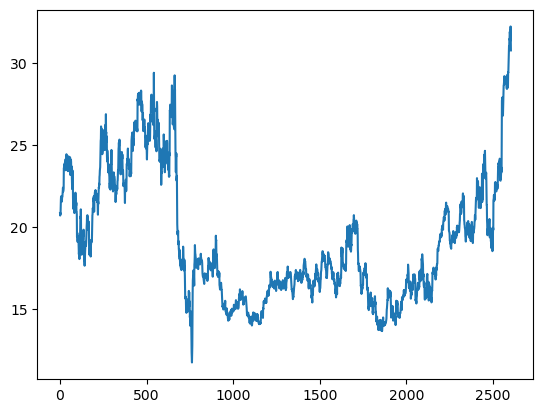

In [4]:
silver['Price'].plot()

# EDA

In [5]:
silver.tail()

Date   Price    Open    High     Low    Vol. Change %
2600  02/01/2013  31.988  31.615  32.095  31.605   0.01K    1.94%
2601  01/31/2013  31.380  31.470  31.845  31.190   0.00K   -2.66%
2602  01/30/2013  32.237  31.405  32.350  31.330   2.54K    3.38%
2603  01/29/2013  31.184  30.850  31.470  30.850  32.35K    1.31%
2604  01/28/2013  30.780  31.160  31.320  30.745  37.83K   -1.37%

In [6]:
len(silver), len(gold), len(copper), len(palladium), len(platinum)

(2605, 2619, 2612, 2878, 3137)

In [7]:
# Check Inflation Data
# https://www.kaggle.com/datasets/varpit94/us-inflation-data-updated-till-may-2021
inflation = pd.read_csv('datasets/Finance/us cpi/US CPI.csv')
inflation

Yearmon      CPI
0     01-01-1913    9.800
1     01-02-1913    9.800
2     01-03-1913    9.800
3     01-04-1913    9.800
4     01-05-1913    9.700
...          ...      ...
1298  01-03-2021  264.877
1299  01-04-2021  267.054
1300  01-05-2021  269.195
1301  01-06-2021  271.696
1302  01-07-2021  273.003

[1303 rows x 2 columns]

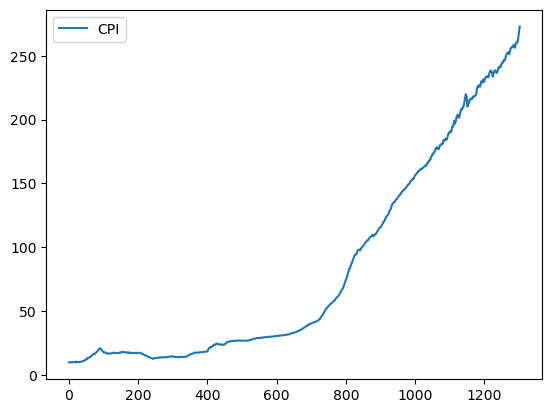

In [8]:
inflation.plot();

In [9]:
# https://www.kaggle.com/datasets/federalreserve/interest-rates
fedrates = pd.read_csv('datasets/Finance/federalreserverates/index.csv')
fedrates

Year  Month  Day  Federal Funds Target Rate  Federal Funds Upper Target  \
0    1954      7    1                        NaN                         NaN   
1    1954      8    1                        NaN                         NaN   
2    1954      9    1                        NaN                         NaN   
3    1954     10    1                        NaN                         NaN   
4    1954     11    1                        NaN                         NaN   
..    ...    ...  ...                        ...                         ...   
899  2016     12   14                        NaN                        0.75   
900  2017      1    1                        NaN                        0.75   
901  2017      2    1                        NaN                        0.75   
902  2017      3    1                        NaN                        0.75   
903  2017      3   16                        NaN                        1.00   

     Federal Funds Lower Target  Effective Federal Funds Rate  \
0                           NaN                          0.80   
1                           NaN                          1.22   
2                           NaN                          1.06   
3                           NaN                          0.85   
4                           NaN                          0.83   
..                          ...                           ...   
899                        0.50                           NaN   
900                        0.50                          0.65   
901                        0.50                          0.66   
902                        0.50                           NaN   
903                        0.75                           NaN   

     Real GDP (Percent Change)  Unemployment Rate  Inflation Rate  
0                          4.6                5.8             NaN  
1                          NaN                6.0             NaN  
2                          NaN                6.1             NaN  
3                          8.0                5.7             NaN  
4                          NaN                5.3             NaN  
..                         ...                ...             ...  
899                        NaN                NaN             NaN  
900                        NaN                4.8             2.3  
901                        NaN                4.7             2.2  
902                        NaN                NaN             NaN  
903                        NaN                NaN             NaN  

[904 rows x 10 columns]

<AxesSubplot: >

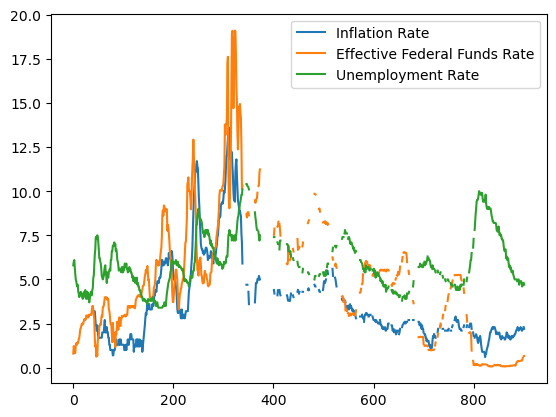

In [10]:
fedrates[['Inflation Rate', 'Effective Federal Funds Rate', 'Unemployment Rate']].plot()

### Missing Data

- Vol has too many missing values so I'm avoiding it.

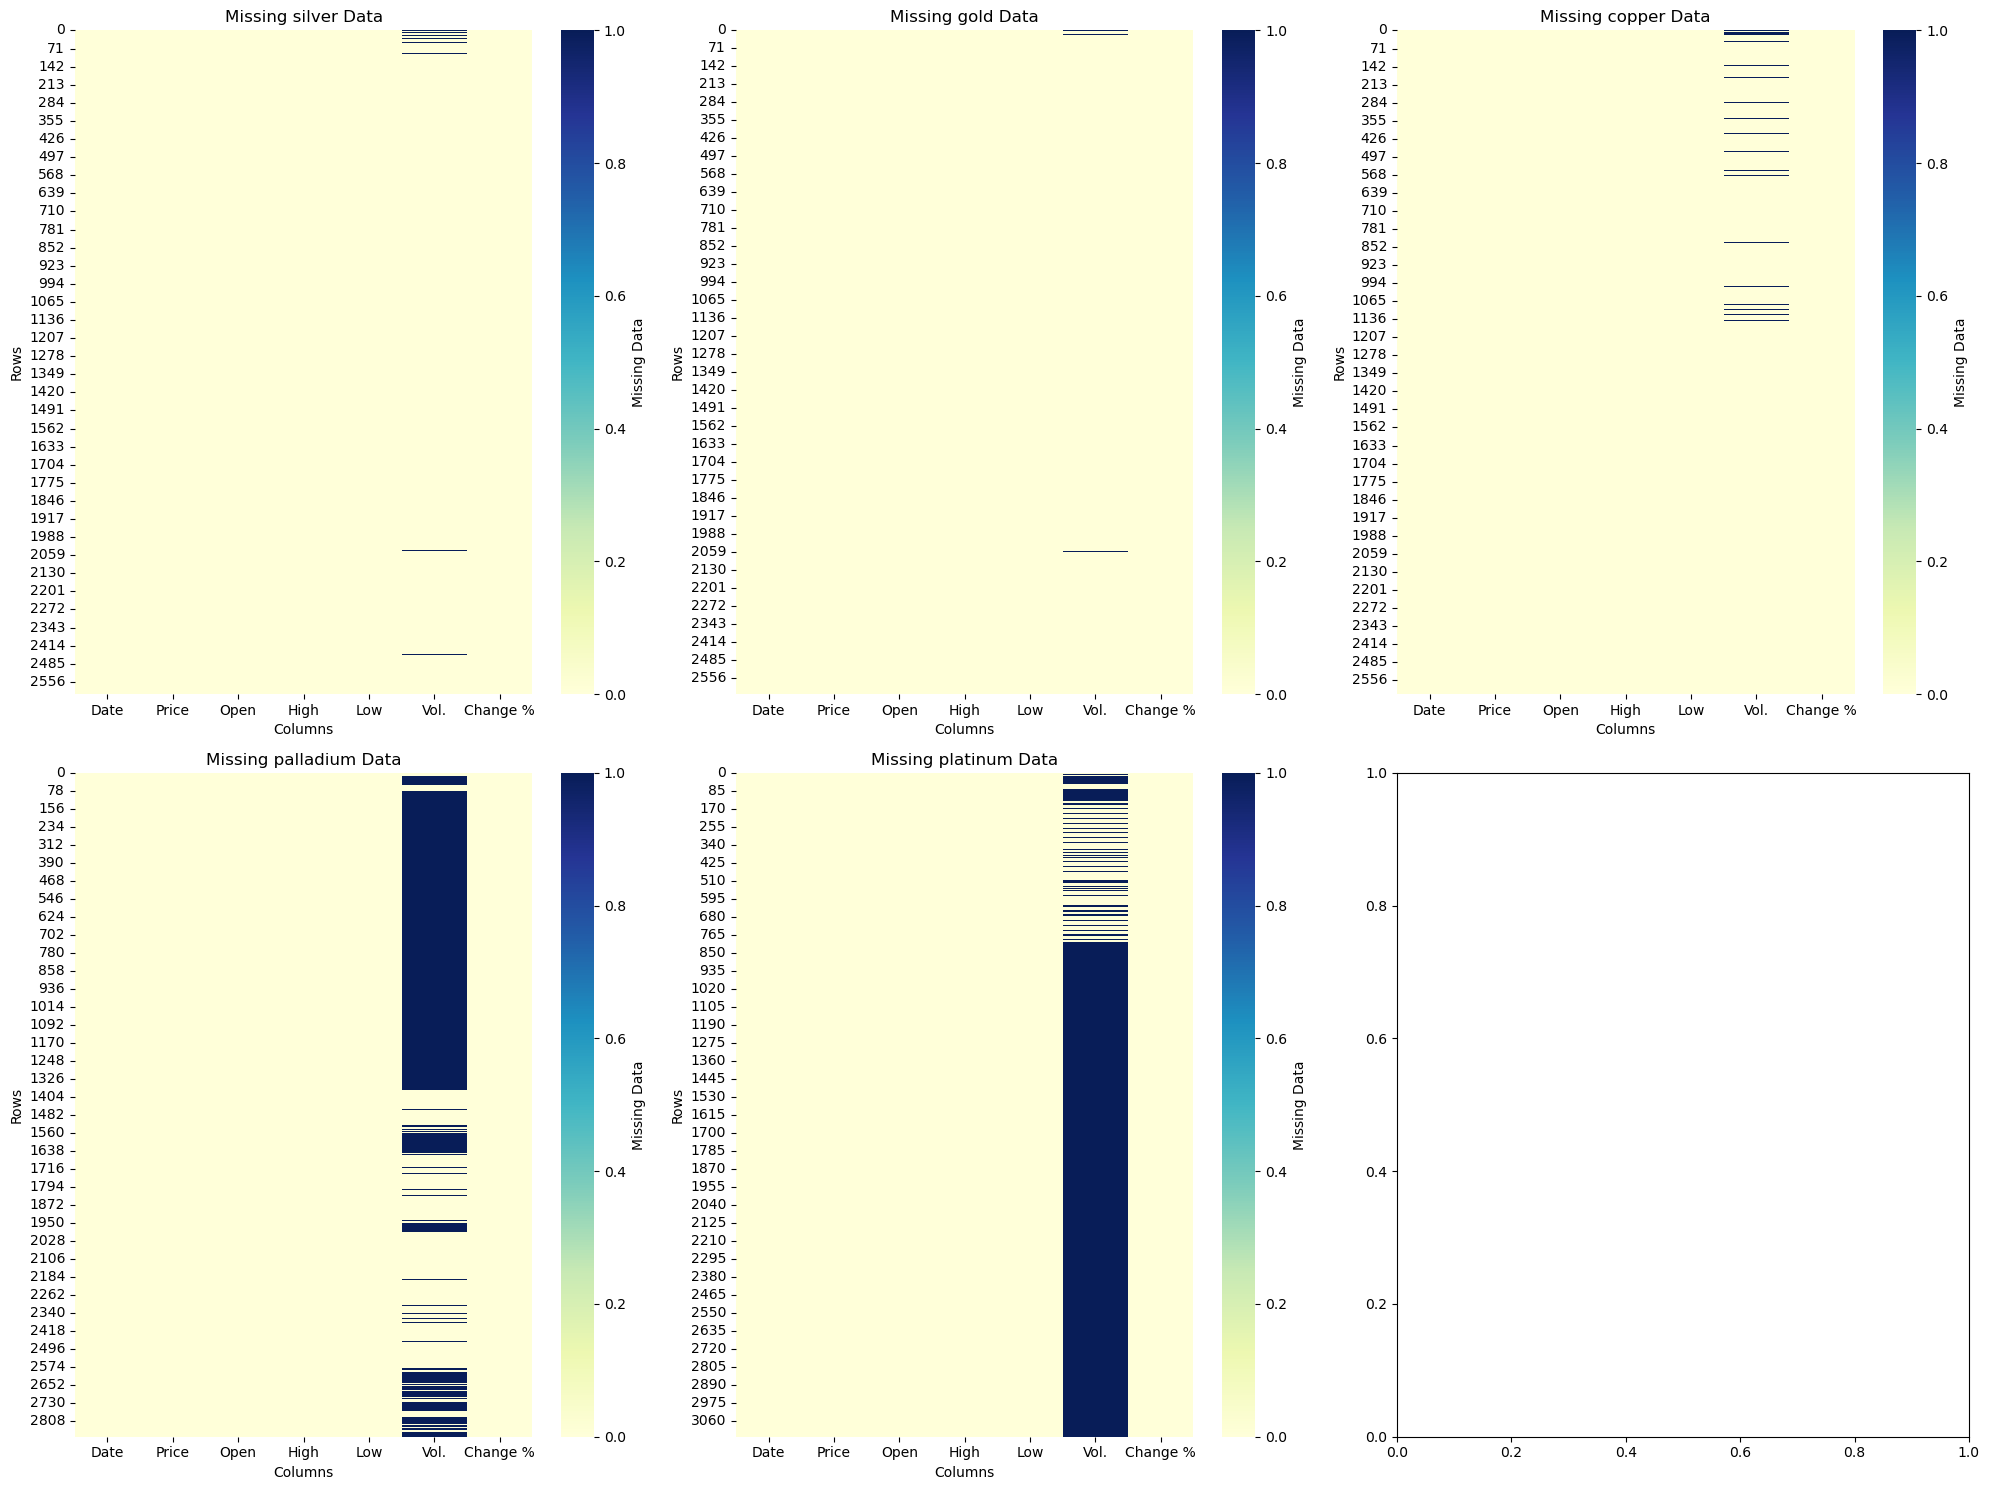

In [11]:
dfs_list = [silver, gold, copper, palladium, platinum]
dfs_list_name = ['silver', 'gold', 'copper', 'palladium', 'platinum']
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 15))
for df, ax, name in zip(dfs_list, axes.flatten(), dfs_list_name):
    sns.heatmap(df.isna(),
                cmap="YlGnBu",
                cbar_kws={'label': 'Missing Data'},
                ax=ax)
    ax.set_title(f"Missing {name} Data")
    ax.set_xlabel("Columns")
    ax.set_ylabel("Rows")

plt.tight_layout()
plt.show()

In [12]:
silver = silver.drop(columns='Vol.')
gold = gold.drop(columns='Vol.')
copper = copper.drop(columns='Vol.')
palladium = palladium.drop(columns='Vol.')
platinum = platinum.drop(columns='Vol.')
print('Removed Vol.')

Removed Vol.


### Addressing the data type problems
 * , for thousand units
 * %

In [13]:
def stringToNumber(data):
    df = data.copy()
    cols = df.columns
    for c in cols:
        if df[c].dtype == 'object':
            df[c] = df[c].str.replace('%', '')  # Remove percentage symbols
            df[c] = df[c].str.replace(',', '')  # Remove thousand separators
            df[c] = df[c].astype(float)  # Convert to float
    return df

silver[['Price', 'Open', 'High', 'Low', 'Change %']] = stringToNumber(silver[['Price', 'Open', 'High', 'Low', 'Change %']])
gold[['Price', 'Open', 'High', 'Low', 'Change %']] = stringToNumber(gold[['Price', 'Open', 'High', 'Low', 'Change %']])
copper[['Price', 'Open', 'High', 'Low', 'Change %']] = stringToNumber(copper[['Price', 'Open', 'High', 'Low', 'Change %']])
palladium[['Price', 'Open', 'High', 'Low', 'Change %']] = stringToNumber(palladium[['Price', 'Open', 'High', 'Low', 'Change %']])
platinum[['Price', 'Open', 'High', 'Low', 'Change %']] = stringToNumber(platinum[['Price', 'Open', 'High', 'Low', 'Change %']])
gold.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2619 entries, 0 to 2618
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      2619 non-null   object 
 1   Price     2619 non-null   float64
 2   Open      2619 non-null   float64
 3   High      2619 non-null   float64
 4   Low       2619 non-null   float64
 5   Change %  2619 non-null   float64
dtypes: float64(5), object(1)
memory usage: 122.9+ KB


In [14]:
# Format date
silver['Date'] = pd.to_datetime(silver['Date'], format='%m/%d/%Y')
gold['Date'] = pd.to_datetime(gold['Date'], format='%m/%d/%Y')
copper['Date'] = pd.to_datetime(copper['Date'], format='%m/%d/%Y')
palladium['Date'] = pd.to_datetime(palladium['Date'], format='%m/%d/%Y')
platinum['Date'] = pd.to_datetime(platinum['Date'], format='%m/%d/%Y')

- If we take a look at the data, there is an inconsistency with the dates. Sometimes it has less sundays, sometimes more, it could be related to global changes in different times or market behaviour.
- There are no saturdays.

In [15]:
def countSundays(dfs):
    for index, d in enumerate(dfs):
        a = d.copy()
        a['Day'] = a['Date'].dt.day_name()
        print(index, a['Day'].value_counts()['Sunday'])
countSundays([silver, gold, copper, palladium, platinum])

0 15
1 3
2 21
3 247
4 517


In [16]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())

print(silver.shape[0])
date_range = pd.date_range(
    platinum['Date'].min(), 
    platinum['Date'].max(), freq=us_bd)
date_df = pd.DataFrame({'Date': date_range})
print(date_df.shape[0])
print('\n')
print(silver[~silver['Date'].isin(date_df['Date'])].shape)
print(gold[~gold['Date'].isin(date_df['Date'])].shape)
print(copper[~copper['Date'].isin(date_df['Date'])].shape)
print(palladium[~palladium['Date'].isin(date_df['Date'])].shape)
print(platinum[~platinum['Date'].isin(date_df['Date'])].shape)
print('\n')
print(date_df[~date_df['Date'].isin(silver['Date'])].shape)
print(date_df[~date_df['Date'].isin(gold['Date'])].shape)
print(date_df[~date_df['Date'].isin(copper['Date'])].shape)
print(date_df[~date_df['Date'].isin(palladium['Date'])].shape)
print(date_df[~date_df['Date'].isin(platinum['Date'])].shape)


2605
2529


(101, 6)
(99, 6)
(89, 6)
(356, 6)
(615, 6)


(25, 1)
(9, 1)
(6, 1)
(7, 1)
(7, 1)


## Data Imputation

In [17]:
date_range = pd.date_range(
    min(silver['Date'].min(), platinum['Date'].min()), 
    max(silver['Date'].max(), platinum['Date'].max()), freq=us_bd
)

date_df = pd.DataFrame({'Date': date_range})

print(
    min(silver['Date'].min(), silver['Date'].min()), 
    max(silver['Date'].max(), silver['Date'].max())
)

merged_df_silver = pd.merge(date_df, silver, how='left', on='Date')
merged_df_gold = pd.merge(date_df, gold, how='left', on='Date')
merged_df_copper = pd.merge(date_df, copper, how='left', on='Date')
merged_df_palladium = pd.merge(date_df, palladium, how='left', on='Date')
merged_df_platinum = pd.merge(date_df, platinum, how='left', on='Date')

print("\nMissing values of silver:   ", merged_df_silver['Price'].isnull().sum())
print("Missing values of gold:      ", merged_df_gold['Price'].isnull().sum())
print("Missing values of copper:    ", merged_df_copper['Price'].isnull().sum())
print("Missing values of palladium: ", merged_df_palladium['Price'].isnull().sum())
print("Missing values of platinum:  ", merged_df_platinum['Price'].isnull().sum())

2013-01-28 00:00:00 2023-02-28 00:00:00

Missing values of silver:    25
Missing values of gold:       9
Missing values of copper:     6
Missing values of palladium:  7
Missing values of platinum:   7


In [18]:
imputer = SimpleImputer(strategy='mean')

columns = merged_df_silver.columns[1:]

imputed_df_silver = merged_df_silver.copy()
imputed_df_gold = merged_df_gold.copy()
imputed_df_copper = merged_df_copper.copy()
imputed_df_palladium = merged_df_palladium.copy()
imputed_df_platinum = merged_df_platinum.copy()

for c in columns:
    imputed_df_silver[c] = imputed_df_silver[c].interpolate(method='linear')
    imputed_df_gold[c] = imputed_df_gold[c].interpolate(method='linear')
    imputed_df_copper[c] = imputed_df_copper[c].interpolate(method='linear')
    imputed_df_palladium[c] = imputed_df_palladium[c].interpolate(method='linear')
    imputed_df_platinum[c] = imputed_df_platinum[c].interpolate(method='linear')


print("\nMissing values of silver:   ", imputed_df_silver['Price'].isnull().sum())
print("Missing values of gold:      ", imputed_df_gold['Price'].isnull().sum())
print("Missing values of copper:    ", imputed_df_copper['Price'].isnull().sum())
print("Missing values of palladium: ", imputed_df_palladium['Price'].isnull().sum())
print("Missing values of platinum:  ", imputed_df_platinum['Price'].isnull().sum())



Missing values of silver:    0
Missing values of gold:       0
Missing values of copper:     0
Missing values of palladium:  0
Missing values of platinum:   0


In [19]:
def plotVariables():
    scaler = MinMaxScaler(feature_range=(-1, 1))
    columns = ['Price', 'Change %']

    for col in columns:
        fig = go.Figure()

        a = imputed_df_silver.copy()
        b = imputed_df_gold.copy()
        c = imputed_df_copper.copy()
        d = imputed_df_palladium.copy()
        e = imputed_df_platinum.copy()

        a[col] = scaler.fit_transform(a[col].to_numpy().reshape(-1, 1))
        b[col] = scaler.fit_transform(b[col].to_numpy().reshape(-1, 1))
        c[col] = scaler.fit_transform(c[col].to_numpy().reshape(-1, 1))
        d[col] = scaler.fit_transform(d[col].to_numpy().reshape(-1, 1))
        e[col] = scaler.fit_transform(e[col].to_numpy().reshape(-1, 1))

        fig.add_trace(go.Scatter(x=a['Date'], y=a[col], mode='lines', name='Silver'))
        fig.add_trace(go.Scatter(x=b['Date'], y=b[col], mode='lines', name='Gold'))
        fig.add_trace(go.Scatter(x=c['Date'], y=c[col], mode='lines', name='Copper'))
        fig.add_trace(go.Scatter(x=d['Date'], y=d[col], mode='lines', name='Palladium'))
        fig.add_trace(go.Scatter(x=e['Date'], y=e[col], mode='lines', name='Platinum'))

        fig.update_layout(title=f'Metals {col} in time', xaxis_title='Date', yaxis_title=col)
        fig.show()
plotVariables()

In [20]:
gc.collect()

973

## Analysis

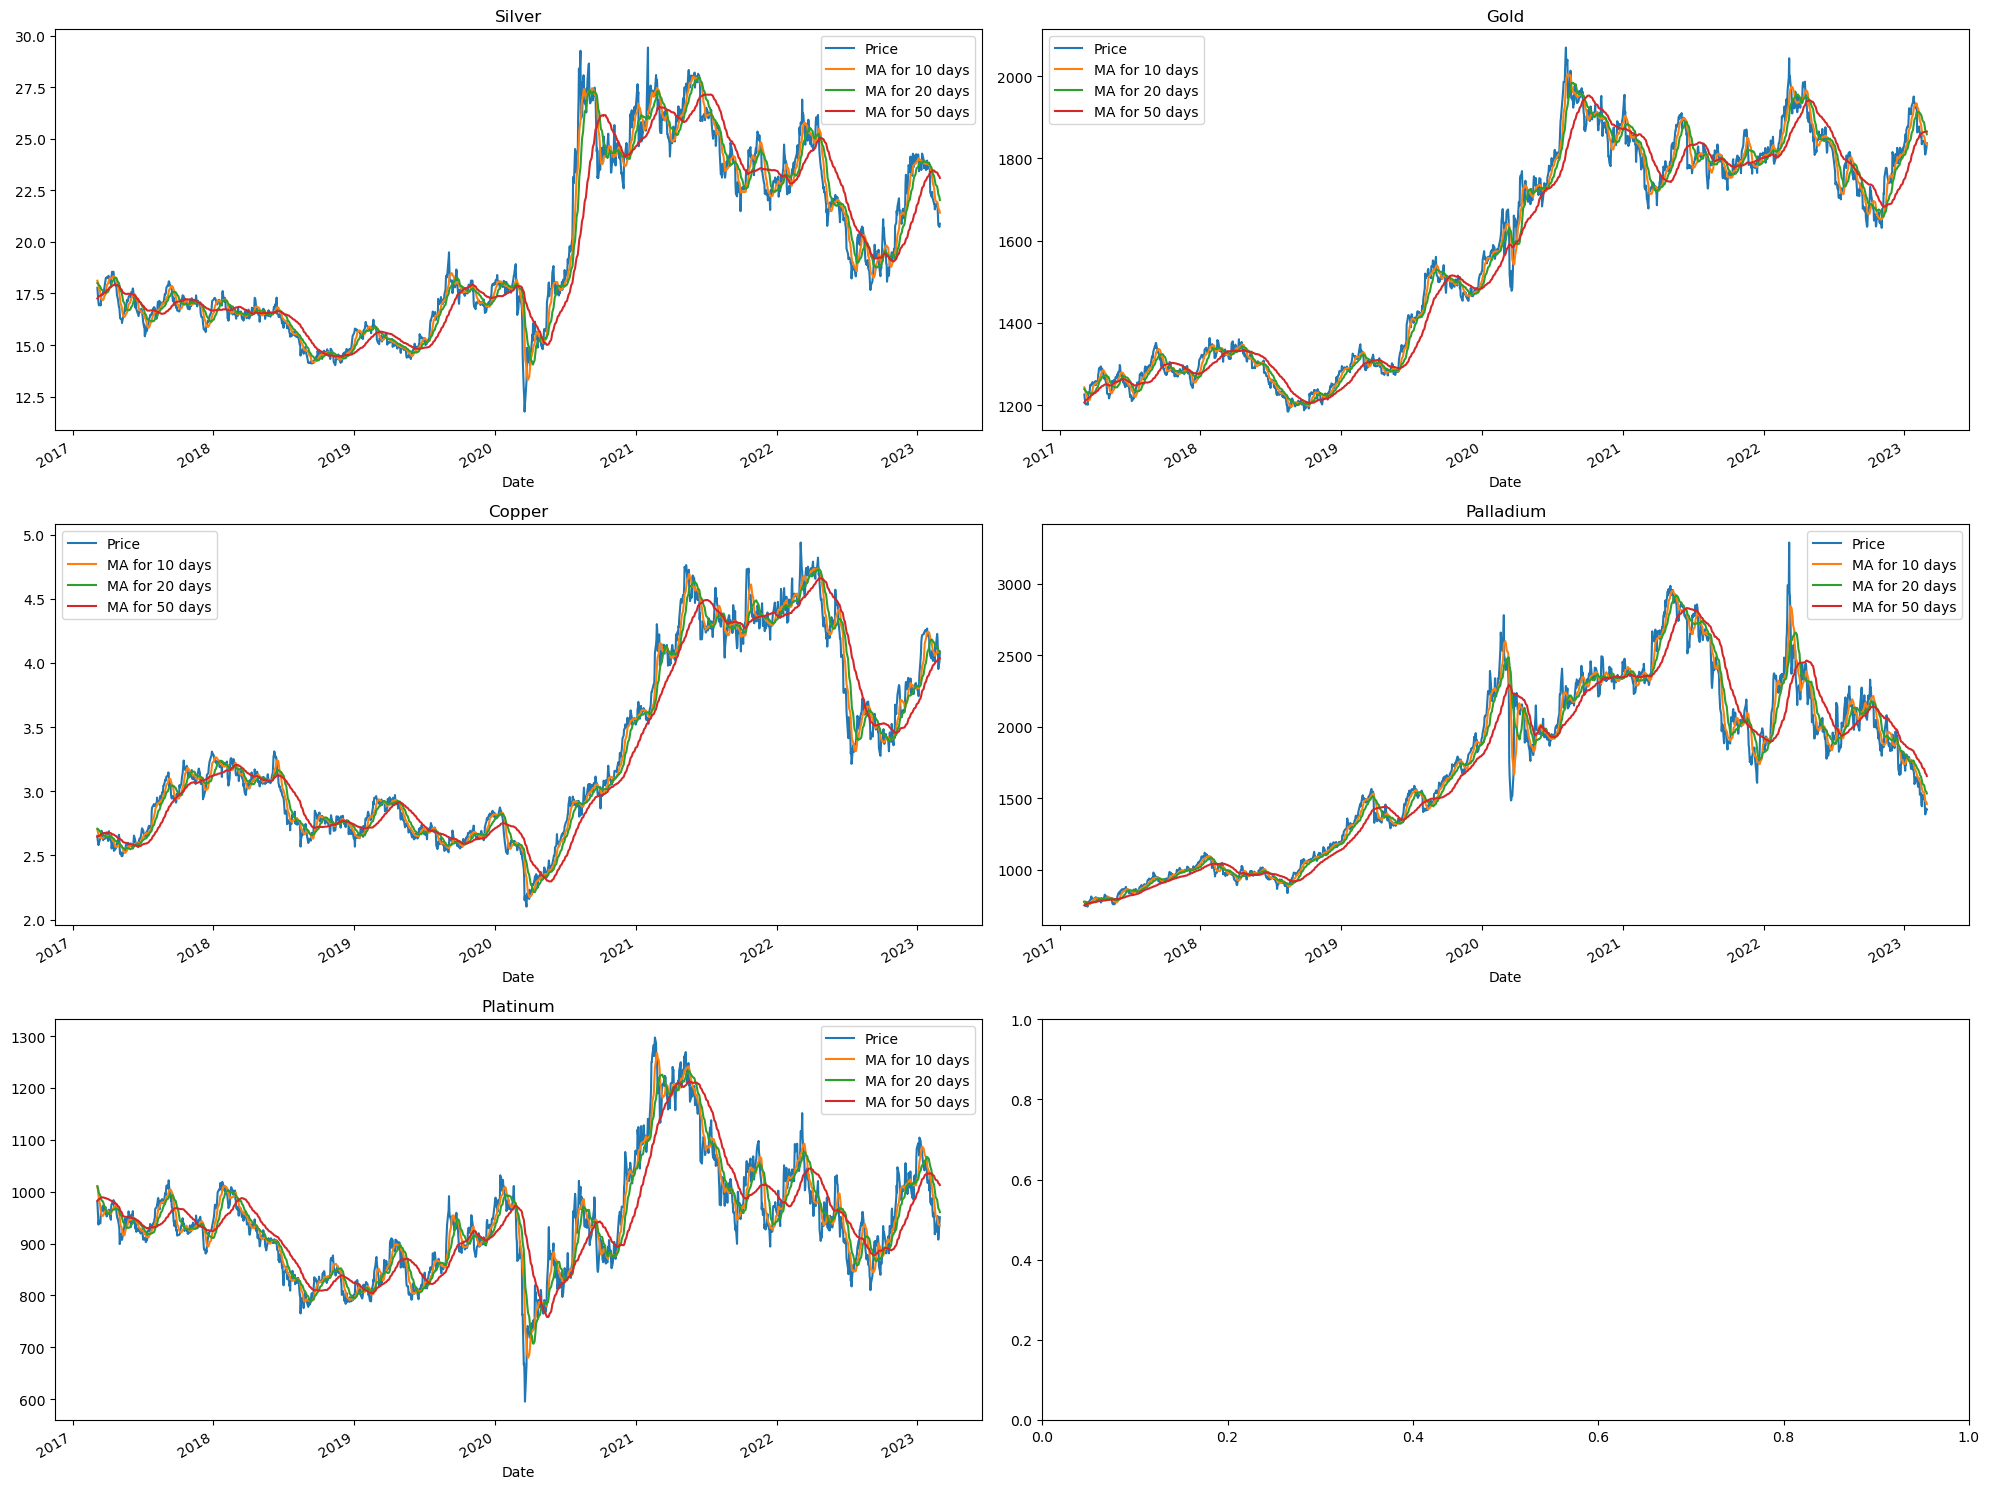

In [21]:
ma_day = [10, 20, 50]

metals = [imputed_df_silver, imputed_df_gold, imputed_df_copper, imputed_df_palladium, imputed_df_platinum]

for ma in ma_day:
    for metal in metals:
        column_name = f"MA for {ma} days"
        metal[column_name] = metal['Price'].rolling(ma).mean()
        
fig, axes = plt.subplots(nrows=3, ncols=2)
fig.set_figheight(15)
fig.set_figwidth(20)

window = 1500

a = imputed_df_silver[-window:].copy()
a = a.set_index(a['Date'])

b = imputed_df_gold[-window:].copy()
b = b.set_index(b['Date'])

c = imputed_df_copper[-window:].copy()
c = c.set_index(c['Date'])

d = imputed_df_palladium[-window:].copy()
d = d.set_index(d['Date'])

e = imputed_df_platinum[-window:].copy()
e = e.set_index(e['Date'])

a[['Price', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[0,0])
axes[0,0].set_title('Silver')

b[['Price', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[0,1])
axes[0,1].set_title('Gold')

c[['Price', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[1,0])
axes[1,0].set_title('Copper')

d[['Price', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[1,1])
axes[1,1].set_title('Palladium')

e[['Price', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes[2,0])
axes[2,0].set_title('Platinum')

fig.tight_layout()


#### MA Conclusion
- The MA 10 crossing above the MA 20 is considered bullish, and the MA 10 crossing below MA 20 bearish and will continue falling. Same with MA 50.
- The significant difference between Price and MA for 50 days of Palladium indicates a higher volatility.
- There is trend confirmation for 2020 (covid effect) showing clearly in all metals.

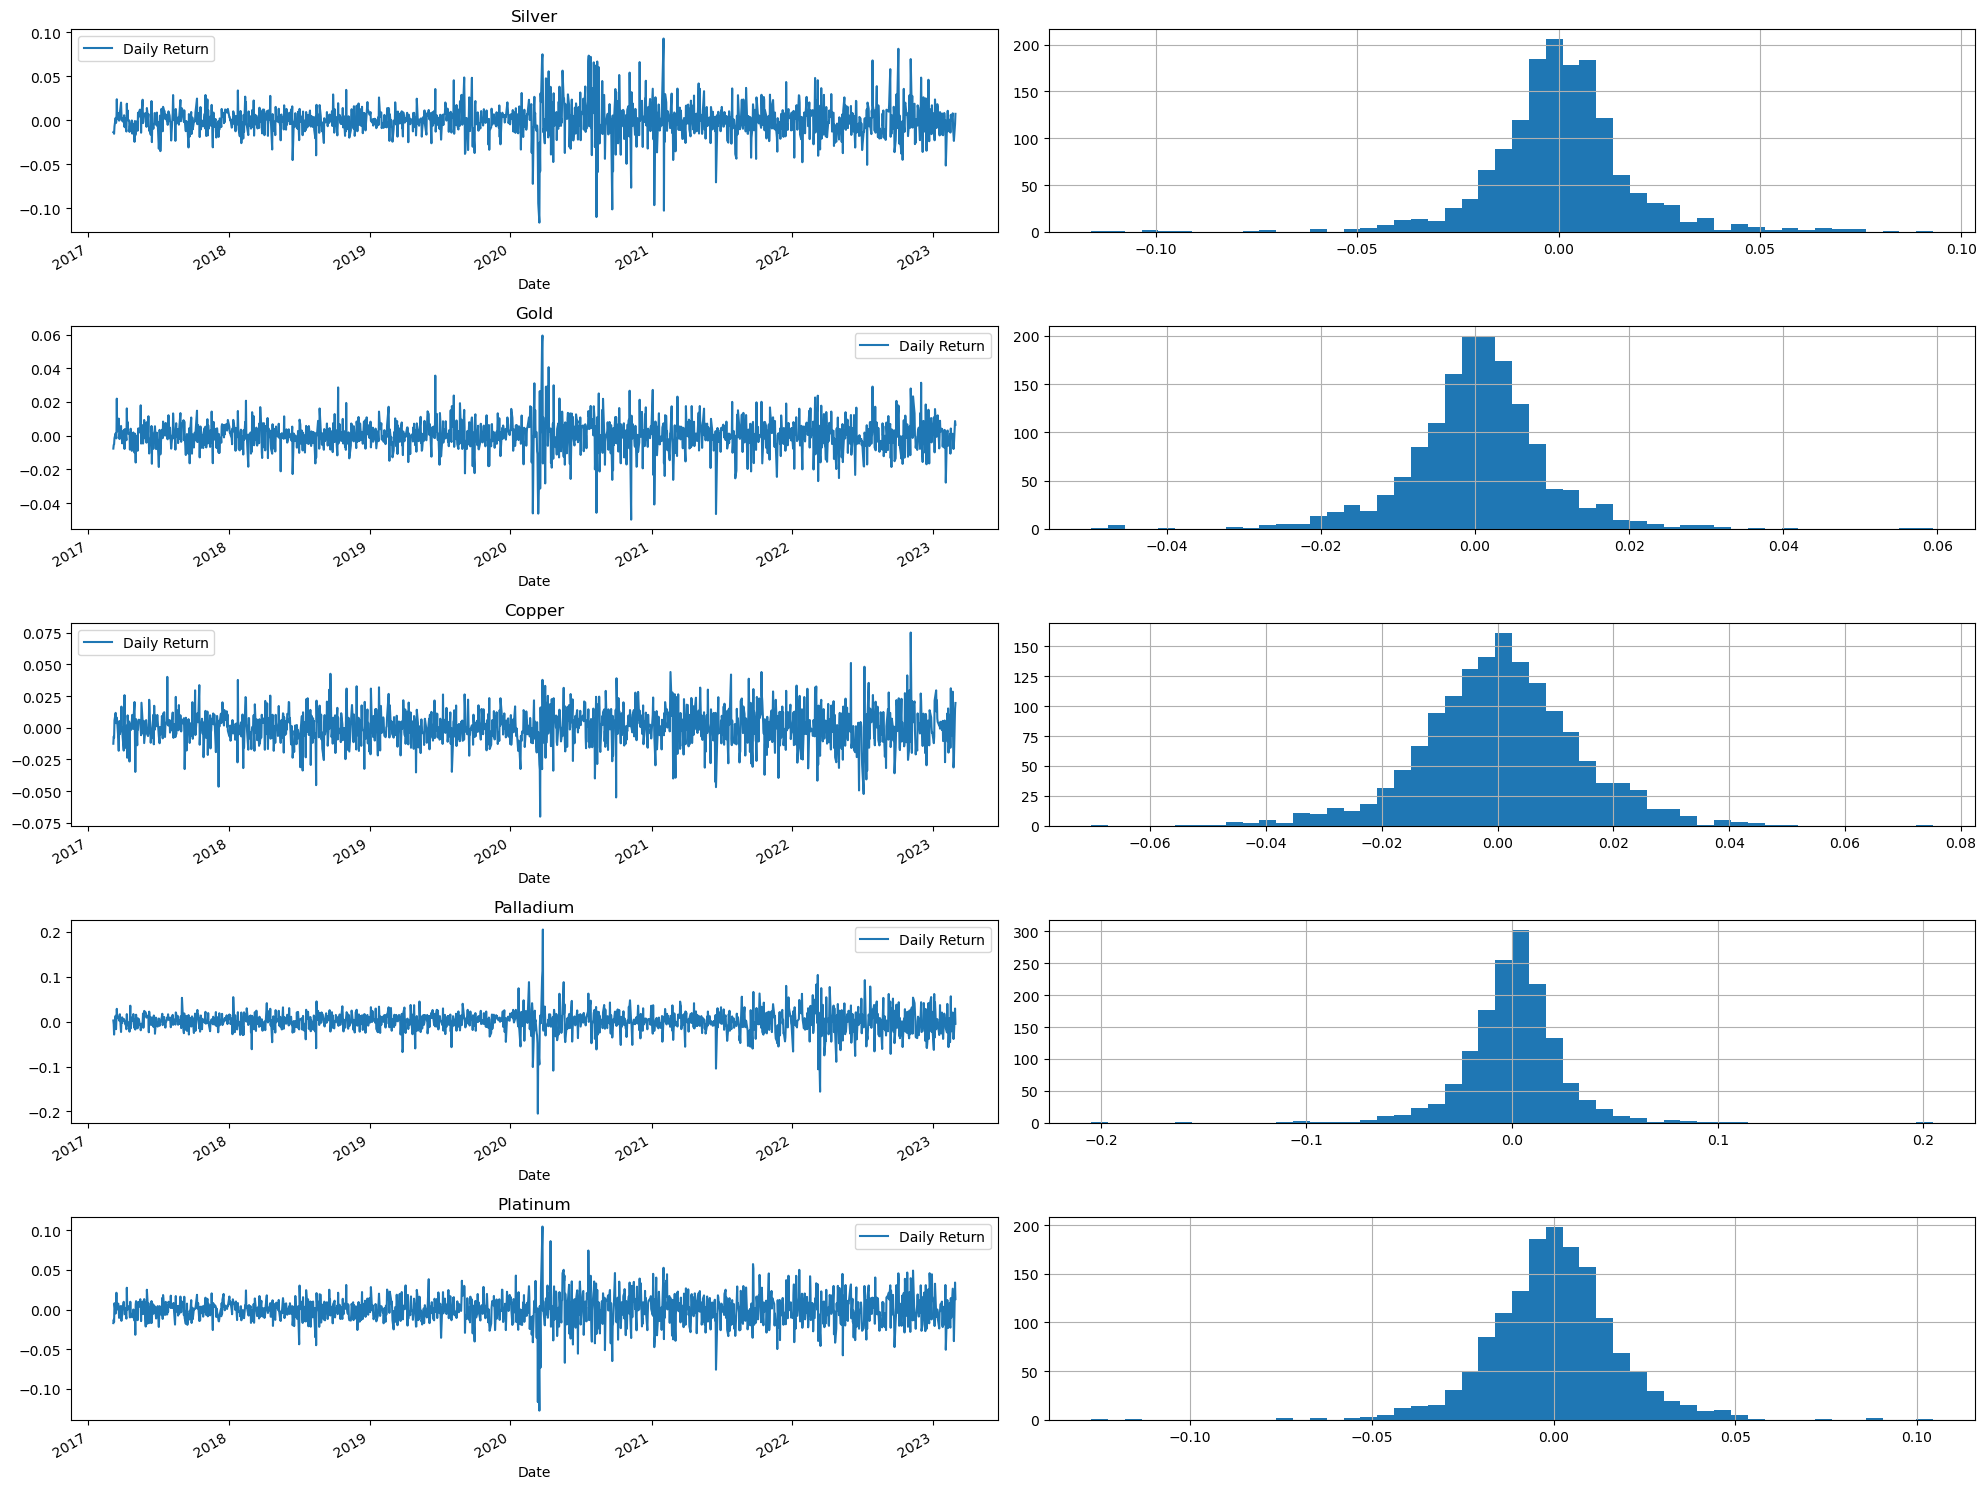

In [22]:
# Percentage of change of each day
metals = [a, b, c, d, e]

for metal in metals:
    metal['Daily Return'] = metal['Price'].pct_change()
        
fig, axes = plt.subplots(nrows=5, ncols=2)
fig.set_figheight(15)
fig.set_figwidth(20)

a[['Daily Return']].plot(ax=axes[0,0])
a['Daily Return'].hist(bins=50, ax=axes[0, 1])
axes[0,0].set_title('Silver')

b[['Daily Return']].plot(ax=axes[1,0])
b['Daily Return'].hist(bins=50, ax=axes[1, 1])
axes[1,0].set_title('Gold')

c[['Daily Return']].plot(ax=axes[2,0])
c['Daily Return'].hist(bins=50, ax=axes[2, 1])
axes[2,0].set_title('Copper')

d[['Daily Return']].plot(ax=axes[3,0])
d['Daily Return'].hist(bins=50, ax=axes[3, 1])
axes[3,0].set_title('Palladium')

e[['Daily Return']].plot(ax=axes[4,0])
e['Daily Return'].hist(bins=50, ax=axes[4, 1])
axes[4,0].set_title('Platinum')

fig.tight_layout()

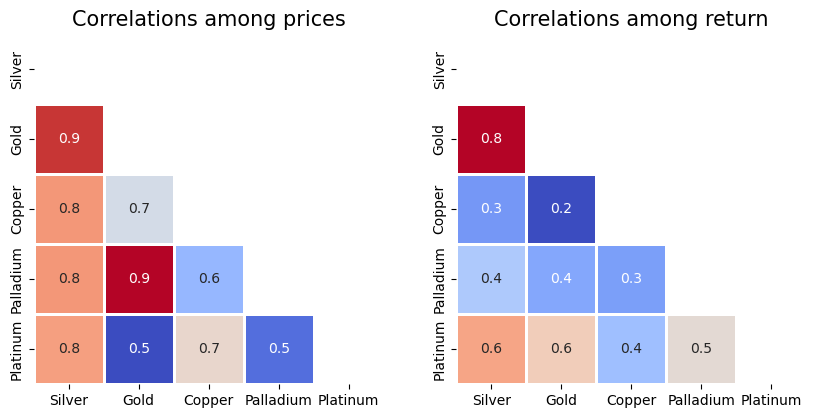

In [23]:
# Correlation of Data
price_corr = pd.concat([a['Price'], b['Price'], c['Price'], d['Price'], e['Price']], axis=1)
price_corr.columns = ['Silver', 'Gold', 'Copper', 'Palladium', 'Platinum']

p_corr = price_corr.copy()
p_corr = p_corr.corr()
mask = np.triu(p_corr.corr())

plt.figure(figsize=(10, 10))

plt.subplot(2, 2, 1)
sns.heatmap(p_corr,
        annot=True,
        fmt='.1f',
        cmap='coolwarm',
        square=True,
        mask=mask,
        linewidths=1,
        cbar=False)
plt.title("Correlations among prices",fontsize = 15)

return_corr = pd.concat([a['Daily Return'], b['Daily Return'], c['Daily Return'], d['Daily Return'], e['Daily Return']], axis=1)
return_corr.columns = ['Silver', 'Gold', 'Copper', 'Palladium', 'Platinum']

r_corr = return_corr.copy()
r_corr = r_corr.corr()
mask = np.triu(r_corr.corr())

plt.subplot(2, 2, 2)
sns.heatmap(r_corr,
        annot=True,
        fmt='.1f',
        cmap='coolwarm',
        square=True,
        mask=mask,
        linewidths=1,
        cbar=False)
plt.title("Correlations among return",fontsize = 15)

plt.show()

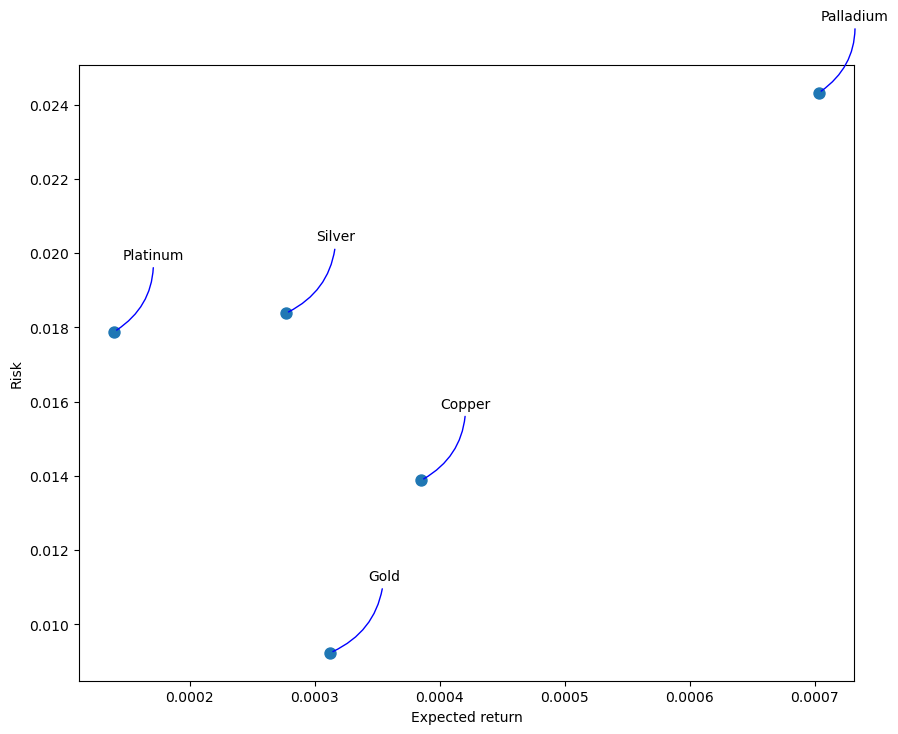

In [24]:
# Risk
rets = return_corr.dropna()

area = np.pi * 20

plt.figure(figsize=(10, 8))
plt.scatter(rets.mean(), rets.std(), s=area)
plt.xlabel('Expected return')
plt.ylabel('Risk')

for label, x, y in zip(rets.columns, rets.mean(), rets.std()):
    plt.annotate(label, xy=(x, y), xytext=(50, 50), textcoords='offset points', ha='right', va='bottom', 
                 arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))

### Percentage of change Conclusion

- The distributions look normal, with a little difference from Copper that has more spread, while others are thiner.
- We need to check the possibility of random walk like in stocks because there could be a lot of randomness involved.

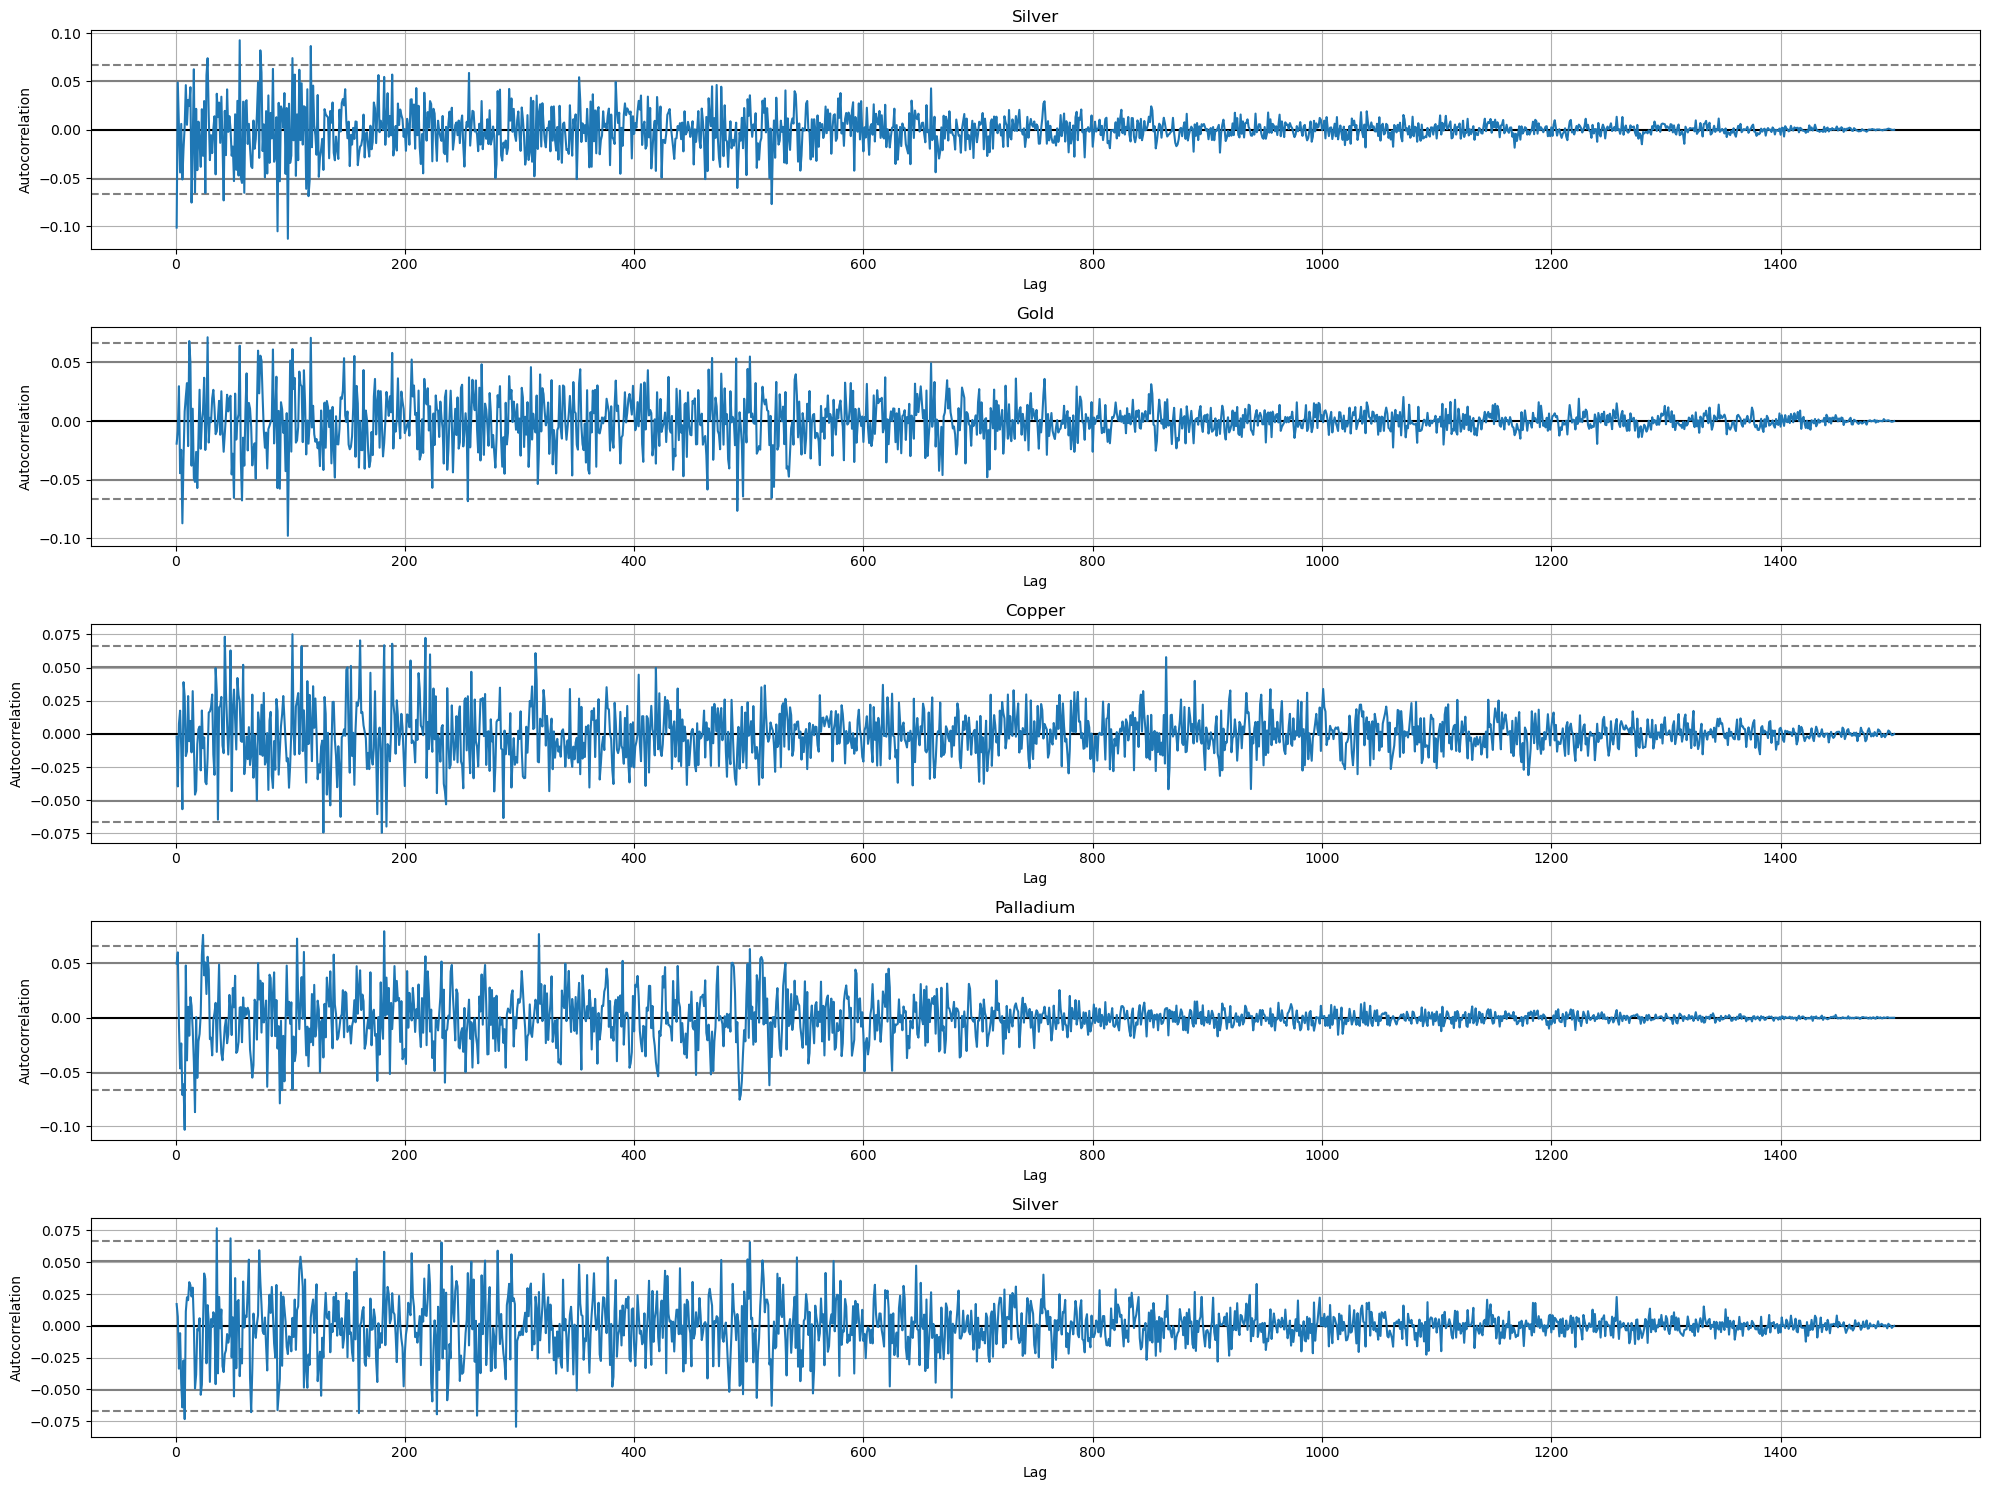

In [25]:
# But, is this data random?
diff_data = []

for metal in metals:
    metaldiff = metal['Price'].diff()
    metaldiff = metaldiff.dropna()
    diff_data.append(pd.DataFrame(metaldiff))

fig, axes = plt.subplots(nrows=5)
fig.set_figheight(15)
fig.set_figwidth(20)

pd.plotting.autocorrelation_plot(diff_data[0], ax=axes[0])
axes[0].set_title('Silver')

pd.plotting.autocorrelation_plot(diff_data[1], ax=axes[1])
axes[1].set_title('Gold')

pd.plotting.autocorrelation_plot(diff_data[2], ax=axes[2])
axes[2].set_title('Copper')

pd.plotting.autocorrelation_plot(diff_data[3], ax=axes[3])
axes[3].set_title('Palladium')

pd.plotting.autocorrelation_plot(diff_data[4], ax=axes[4])
axes[4].set_title('Silver')

fig.tight_layout()

### ACF and PACF

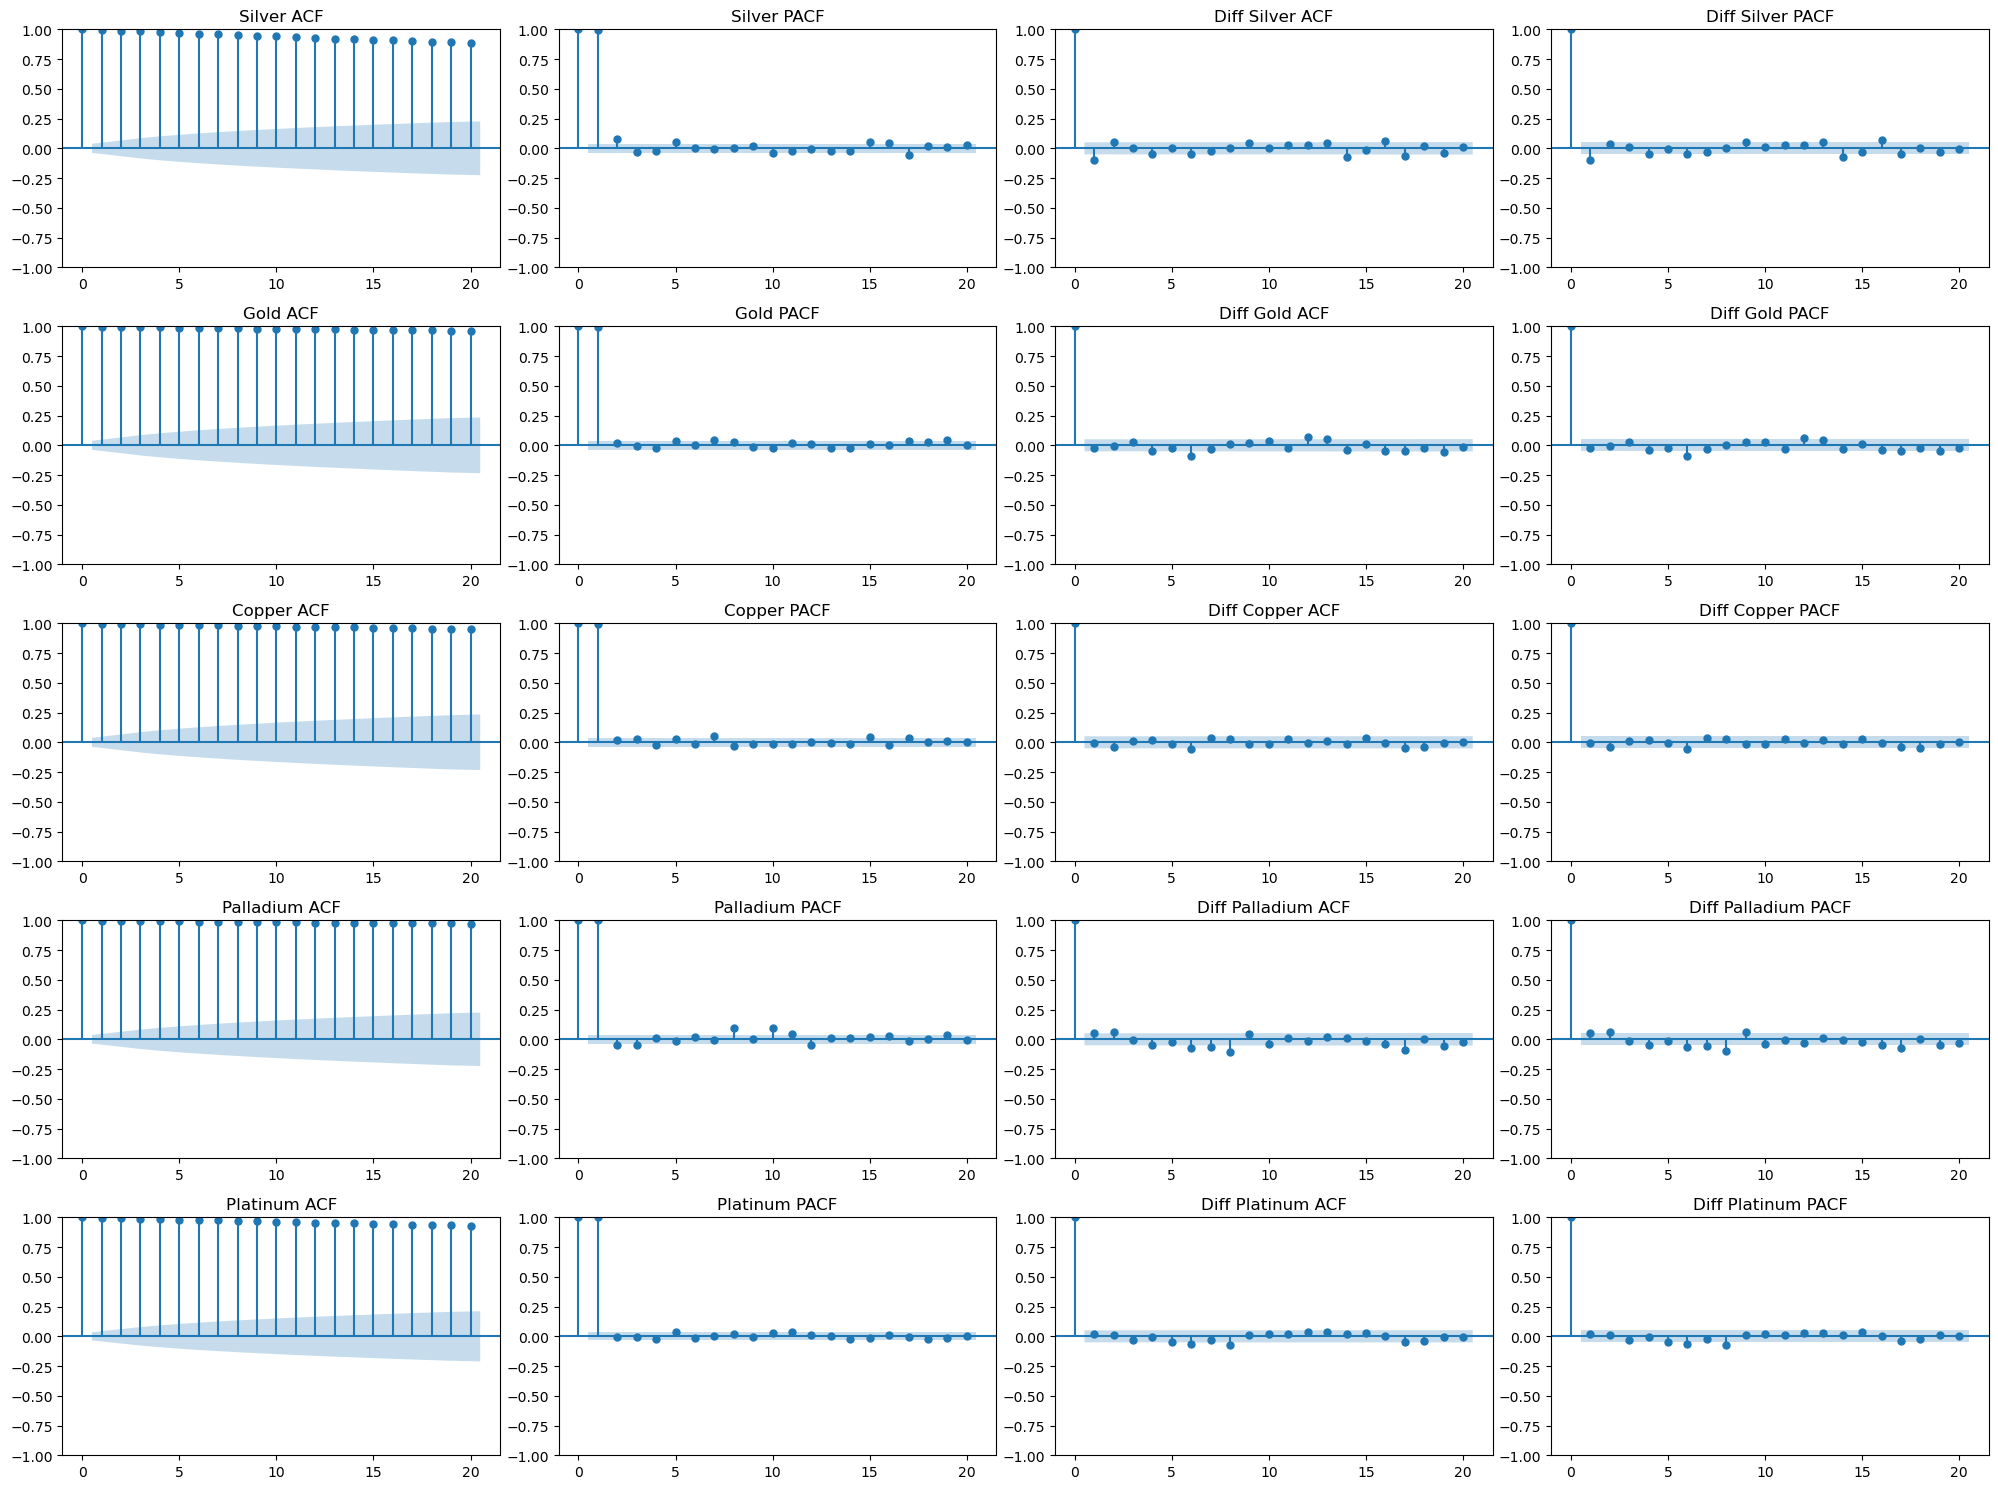

In [26]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

n_lags = 20

f, ax = plt.subplots(nrows=5, ncols=4, figsize=(20, 15))

plot_acf(silver['Price'],lags=n_lags, ax=ax[0, 0])
plot_pacf(silver['Price'],lags=n_lags, ax=ax[0, 1], method='ols')
plot_acf(diff_data[0],lags=n_lags, ax=ax[0, 2])
plot_pacf(diff_data[0],lags=n_lags, ax=ax[0, 3], method='ols')
ax[0,0].set_title('Silver ACF')
ax[0,1].set_title('Silver PACF')
ax[0,2].set_title('Diff Silver ACF')
ax[0,3].set_title('Diff Silver PACF')

plot_acf(gold['Price'],lags=n_lags, ax=ax[1, 0])
plot_pacf(gold['Price'],lags=n_lags, ax=ax[1, 1], method='ols')
plot_acf(diff_data[1],lags=n_lags, ax=ax[1, 2])
plot_pacf(diff_data[1],lags=n_lags, ax=ax[1, 3], method='ols')
ax[1,0].set_title('Gold ACF')
ax[1,1].set_title('Gold PACF')
ax[1,2].set_title('Diff Gold ACF')
ax[1,3].set_title('Diff Gold PACF')

plot_acf(copper['Price'],lags=n_lags, ax=ax[2, 0])
plot_pacf(copper['Price'],lags=n_lags, ax=ax[2, 1], method='ols')
plot_acf(diff_data[2],lags=n_lags, ax=ax[2, 2])
plot_pacf(diff_data[2],lags=n_lags, ax=ax[2, 3], method='ols')
ax[2,0].set_title('Copper ACF')
ax[2,1].set_title('Copper PACF')
ax[2,2].set_title('Diff Copper ACF')
ax[2,3].set_title('Diff Copper PACF')

plot_acf(palladium['Price'],lags=n_lags, ax=ax[3, 0])
plot_pacf(palladium['Price'],lags=n_lags, ax=ax[3, 1], method='ols')
plot_acf(diff_data[3],lags=n_lags, ax=ax[3, 2])
plot_pacf(diff_data[3],lags=n_lags, ax=ax[3, 3], method='ols')
ax[3,0].set_title('Palladium ACF')
ax[3,1].set_title('Palladium PACF')
ax[3,2].set_title('Diff Palladium ACF')
ax[3,3].set_title('Diff Palladium PACF')

plot_acf(platinum['Price'],lags=n_lags, ax=ax[4, 0])
plot_pacf(platinum['Price'],lags=n_lags, ax=ax[4, 1], method='ols')
plot_acf(diff_data[4],lags=n_lags, ax=ax[4, 2])
plot_pacf(diff_data[4],lags=n_lags, ax=ax[4, 3], method='ols')
ax[4,0].set_title('Platinum ACF')
ax[4,1].set_title('Platinum PACF')
ax[4,2].set_title('Diff Platinum ACF')
ax[4,3].set_title('Diff Platinum PACF')

plt.tight_layout()
plt.show()

### Analysis
- Given the ACF and PACF results, the data is considered to be Random Walk, which means it cannot be reasonably predicted.
- What we can do is use a function on the observations on the previous setps (and MA) for the next time step.

# Setup

In [27]:
metals = [imputed_df_silver, imputed_df_gold, imputed_df_copper, imputed_df_palladium, imputed_df_platinum]
for m in metals:
    m.columns = m.columns.str.replace(' ', '_')
imputed_df_silver.columns

Index(['Date', 'Price', 'Open', 'High', 'Low', 'Change_%', 'MA_for_10_days',
       'MA_for_20_days', 'MA_for_50_days'],
      dtype='object')

In [28]:
# Test
"""def upper_shadow(df):
    return df['High'] - np.maximum(df['Price'], df['Open'])

def lower_shadow(df):
    return np.minimum(df['Price'], df['Open']) - df['Low']
"""
def get_lags(df):
    lags = [10,20,50]
    df_out = pd.DataFrame()

    for col in df.columns:

        for lag in lags:
            df_out[f'{col}_Lag_{lag}'] = df[col].shift(lag)
            df_out[f'log_close/mean_{lag}'] = np.log( np.array(df[col]) /  np.roll(np.append(np.convolve( np.array(df[col]), np.ones(lag)/lag, mode="valid"), np.ones(lag-1)), lag-1))
            df_out[f'log_return_{lag}']     = np.log( np.array(df[col]) /  np.roll(np.array(df[col]), lag))

        for lag in lags:
            df_out[f'mean_close/mean_{lag}'] =  np.mean(df_out.iloc[:,df_out.columns.str.startswith(f'log_close/mean_{lag}')], axis=1)
            df_out[f'mean_log_returns_{lag}'] = np.mean(df_out.iloc[:,df_out.columns.str.startswith(f'log_return_{lag}')] ,    axis=1)

            df_out[f'log_close/mean_{lag}-mean_close/mean_{lag}'] = np.array( df_out[f'log_close/mean_{lag}']) - np.array( df_out[f'mean_close/mean_{lag}']  )
            df_out[f'log_return_{lag}-mean_log_returns_{lag}']    = np.array( df_out[f'log_return_{lag}'])     - np.array( df_out[f'mean_log_returns_{lag}'] )

    return df_out

def get_date_features(df):
    df_copy = df.copy()
    df_copy['Date'] = pd.to_datetime(df_copy['Date'])
    df_copy['Year'] = df_copy['Date'].dt.year
    df_copy['Month'] = df_copy['Date'].dt.month
    df_copy['Week_Number'] = df_copy['Date'].dt.isocalendar().week
    return df_copy

def get_features(df, max_date='01/01/2013'):
    #df_feat = df[['Price', 'Change_%', 'MA_for_10_days', 'MA_for_20_days', 'MA_for_50_days']].copy() # 'Open', 'High', 'Low', , 
    #df_feat = pd.concat([df_feat, get_lags(df_feat[['MA_for_10_days', 'MA_for_20_days', 'MA_for_50_days']])], axis=1)
    #df_feat['Upper Shadow'] = upper_shadow(df_feat)
    #df_feat['Lower Shadow'] = lower_shadow(df_feat)
    
    # Time window
    df_range = df[df['Date'] >= max_date]

    # Fatures to lag
    df_feat = get_lags(df_range[['Price']])

    # Date features
    date_df = df_range[['Date']].copy()
    date_df['Date'] = pd.to_datetime(date_df['Date'])
    df_feat = pd.concat([df_feat, get_date_features(date_df), df_range[['Price']]], axis=1)
    df_feat['Price'] = df_feat['Price'].shift(-1)
    df_feat.dropna(inplace=True)
    return df_feat

In [29]:
max_date = "01/01/2013"
df_silver = get_features(imputed_df_silver, max_date)
df_gold = get_features(imputed_df_gold, max_date)
df_copper = get_features(imputed_df_copper, max_date)
df_palladium = get_features(imputed_df_palladium, max_date)
df_platinum = get_features(imputed_df_platinum, max_date)
dfs_metals = [df_silver, df_gold, df_copper, df_palladium, df_platinum]
df_silver.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2478 entries, 50 to 2527
Data columns (total 26 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   Price_Lag_10                          2478 non-null   float64       
 1   log_close/mean_10                     2478 non-null   float64       
 2   log_return_10                         2478 non-null   float64       
 3   Price_Lag_20                          2478 non-null   float64       
 4   log_close/mean_20                     2478 non-null   float64       
 5   log_return_20                         2478 non-null   float64       
 6   Price_Lag_50                          2478 non-null   float64       
 7   log_close/mean_50                     2478 non-null   float64       
 8   log_return_50                         2478 non-null   float64       
 9   mean_close/mean_10                    2478 non-null   float64       
 10 

In [30]:
seed0 = 69

In [31]:
params = {
    'early_stopping_rounds': 50,
    'objective': 'regression',
    'metric': 'rmse',
#     'metric': 'None',
    'boosting_type': 'gbdt',
    'max_depth': 5,
    'verbose': -1,
    'max_bin':600,
    'min_data_in_leaf':50,
    'learning_rate': 0.03,
    'subsample': 0.7,
    'subsample_freq': 1,
    'feature_fraction': 1,
    'lambda_l1': 0.5,
    'lambda_l2': 2,
    'seed':seed0,
    'feature_fraction_seed': seed0,
    'bagging_fraction_seed': seed0,
    'drop_seed': seed0,
    'data_random_seed': seed0,
    'extra_trees': True,
    'extra_seed': seed0,
    'zero_as_missing': True,
    "first_metric_only": True
         }

In [32]:
# define the evaluation metric
def correlation(a, train_data):
    
    b = train_data.get_label()
    
    a = np.ravel(a)
    b = np.ravel(b)

    len_data = len(a)
    mean_a = np.sum(a) / len_data
    mean_b = np.sum(b) / len_data
    var_a = np.sum(np.square(a - mean_a)) / len_data
    var_b = np.sum(np.square(b - mean_b)) / len_data

    cov = np.sum((a * b))/len_data - mean_a*mean_b
    corr = cov / np.sqrt(var_a * var_b)

    return 'corr', corr, True

# For CV score calculation
def corr_score(pred, valid):
    len_data = len(pred)
    mean_pred = np.sum(pred) / len_data
    mean_valid = np.sum(valid) / len_data
    var_pred = np.sum(np.square(pred - mean_pred)) / len_data
    var_valid = np.sum(np.square(valid - mean_valid)) / len_data

    cov = np.sum((pred * valid))/len_data - mean_pred*mean_valid
    corr = cov / np.sqrt(var_pred * var_valid)

    return corr

# For CV score calculation
def wcorr_score(pred, valid, weight):
    len_data = len(pred)
    sum_w = np.sum(weight)
    mean_pred = np.sum(pred * weight) / sum_w
    mean_valid = np.sum(valid * weight) / sum_w
    var_pred = np.sum(weight * np.square(pred - mean_pred)) / sum_w
    var_valid = np.sum(weight * np.square(valid - mean_valid)) / sum_w

    cov = np.sum((pred * valid * weight)) / sum_w - mean_pred*mean_valid
    corr = cov / np.sqrt(var_pred * var_valid)

    return corr

In [33]:
def getTarget(df):
    return df['Price']

def getX_y(df):
    df_proc = df.copy()
    df_proc['y'] = getTarget(df)
    #df_proc = df_proc.dropna(how="any")
    
    X = df_proc.drop(['y', 'Price', 'Date'], axis=1) # Remove target from data
    y = df_proc["y"]
    return X, y

In [34]:
names = ['Silver', 'Gold', 'Copper', 'Palladium', 'Platinum']

In [35]:
def runExperiment():
    dfs = [df_silver, df_gold, df_copper, df_palladium, df_platinum]
    #scaler = MinMaxScaler(feature_range=(-1,1))
    #scaler = StandardScaler()

    results={}

    for d, name in zip(dfs, names):
        data = d
        split = int(data.shape[0] * 0.2)

        test = data[-split:]
        train = data[:-split]

        X_train, y_train = getX_y(train)

        #X_train = scaler.fit_transform(X_train)

        X_test, y_test = getX_y(test)

        #X_test = scaler.fit_transform(X_test)

        train_dataset = lgb.Dataset(X_train,
                                    y_train 
                                   )
        val_dataset = lgb.Dataset(X_test,
                                  y_test
                                 )
        # Model
        model = lgb.train(
                        params = params,
                        train_set = train_dataset, 
                        valid_sets=[train_dataset, val_dataset],
                        valid_names=['tr', 'vl'],
                        num_boost_round = 5000,    
                        feval = correlation,
                        )

        y_pred = model.predict(X_test)

        results[name] = {'X_test': X_test, 'y_test': y_test, 'y_pred': y_pred, 'model': model}

    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 15))
    for ax, name in zip(axes.flatten(), names):
        y_test = results[name]['y_test']
        y_pred = results[name]['y_pred']
        
        df = pd.DataFrame([y_test.values, y_pred]).T.reset_index(drop=True)
        df.columns = ['Test', 'Prediction']
        df.plot(ax=ax);

        ax.set_title(f"Training {name}")
        ax.set_xlabel("Columns")
        ax.set_ylabel(f"{name}")

    clear_output(wait=True)

    for name in names:
        y_test = results[name]['y_test']
        y_pred = results[name]['y_pred']
        print(f'{name} MSE:\t\t', mean_squared_error(y_test, y_pred))

    plt.tight_layout()
    plt.show()

    return results
    

Silver MSE:		 1.2411111155987302
Gold MSE:		 1860.100540735349
Copper MSE:		 0.5222632661500679
Palladium MSE:		 58249.64042935739
Platinum MSE:		 1170.770407885028


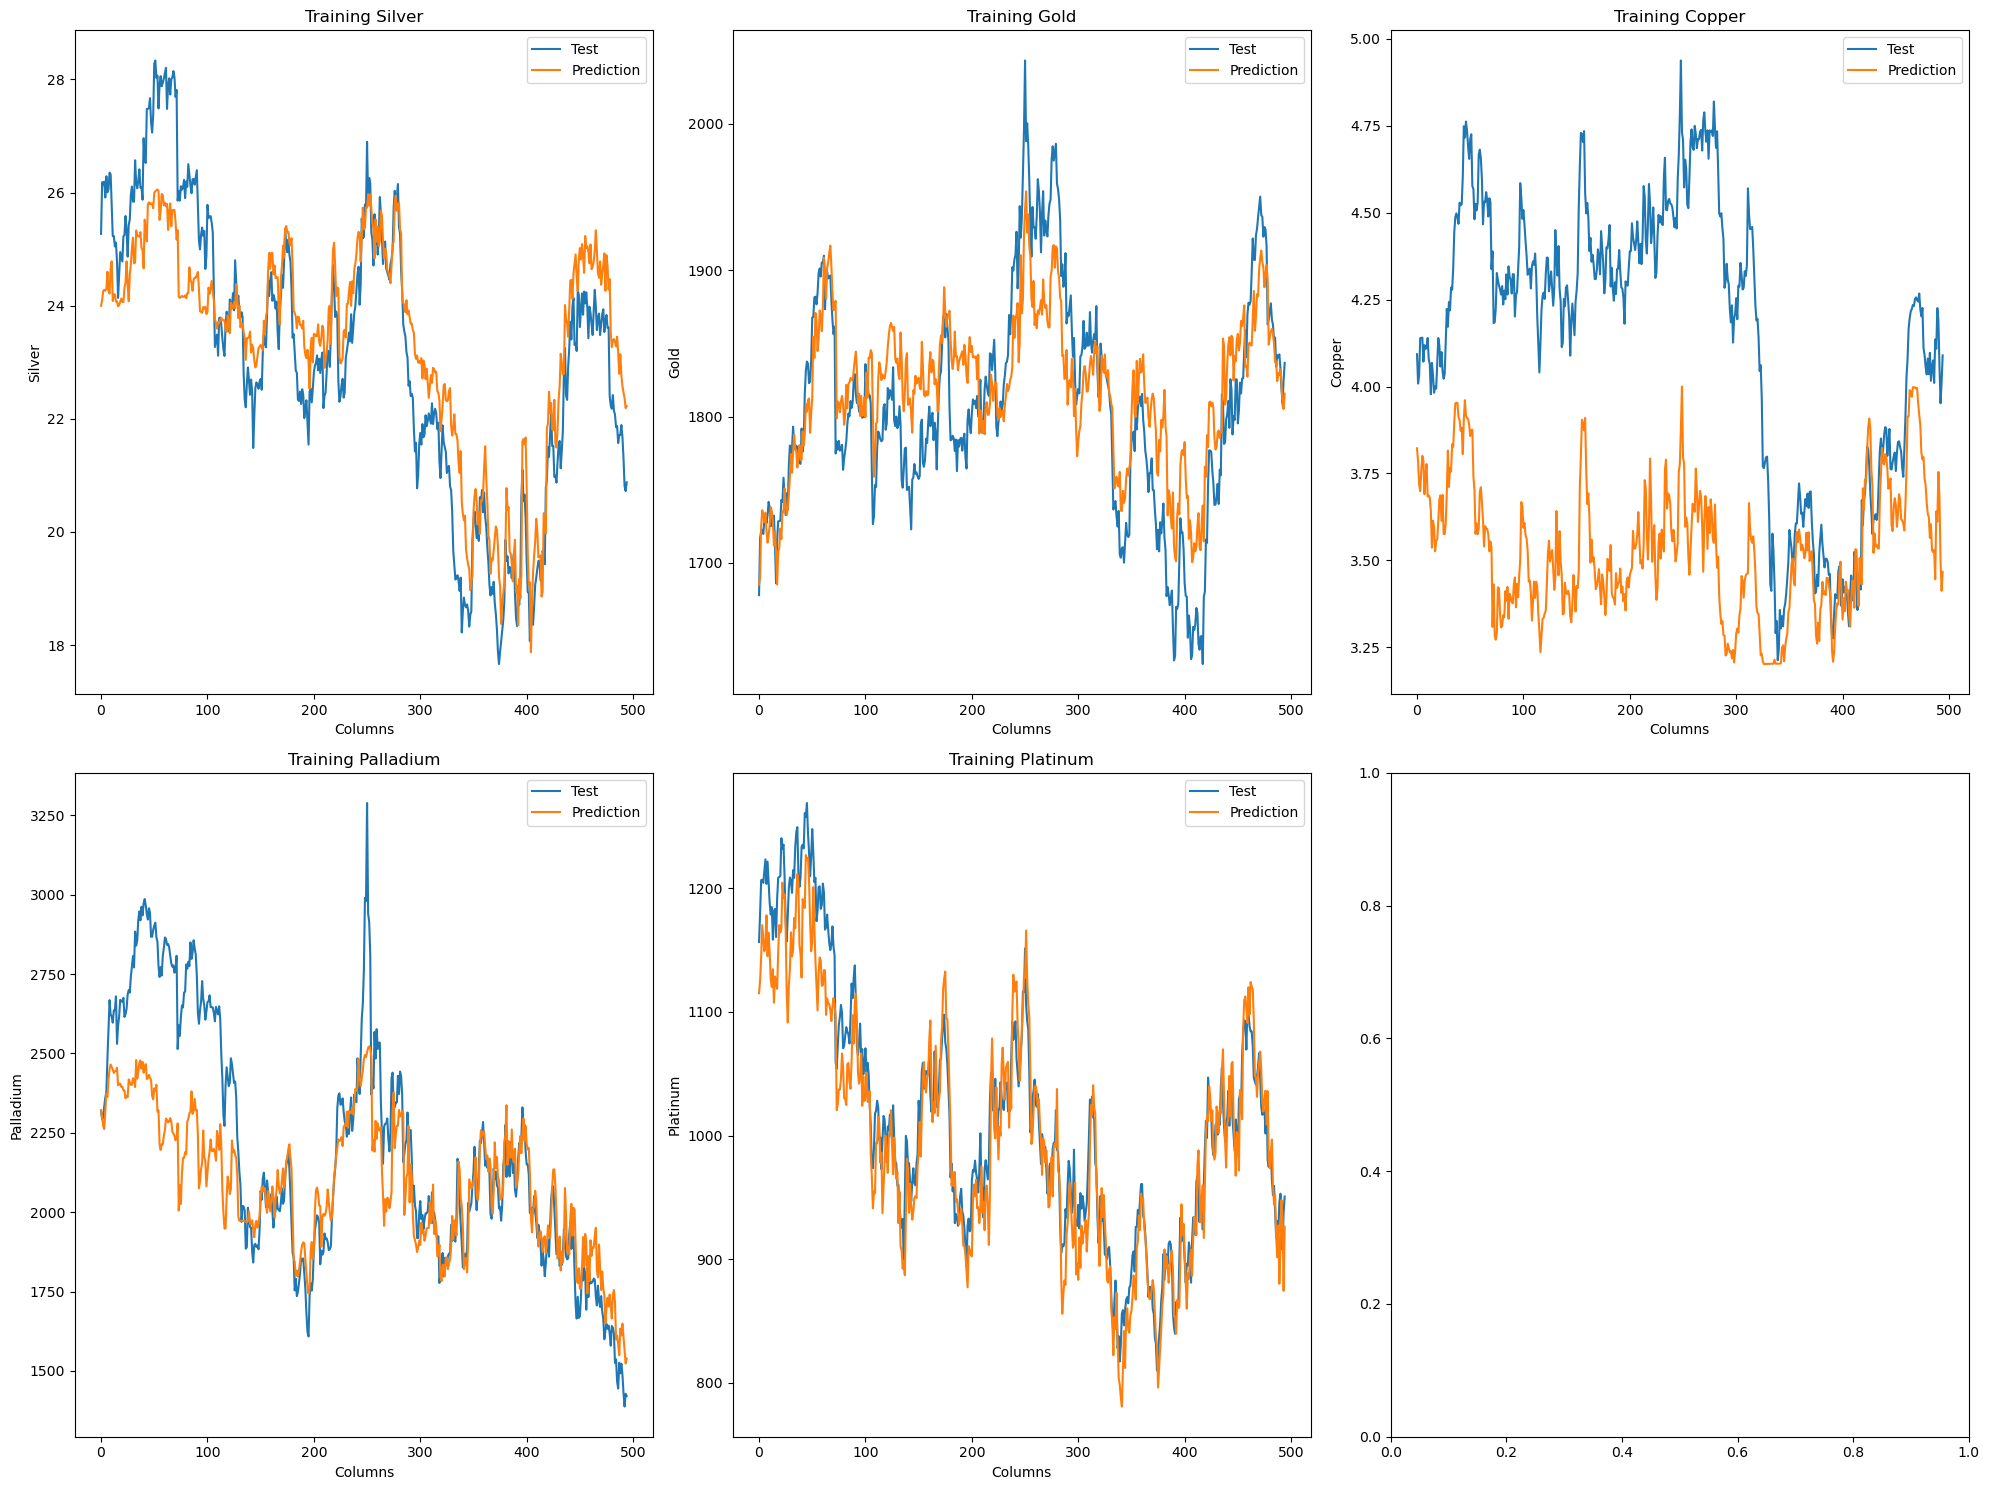

In [36]:
# Standalone results
results = runExperiment()

In [37]:
explainer = shap.Explainer(results['Silver']['model'])
shap_values = explainer.shap_values(results['Silver']['X_test'])

/home/stare/anaconda3/envs/test-env/lib/python3.8/site-packages/shap/plots/_beeswarm.py:699: UserWarning:

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored



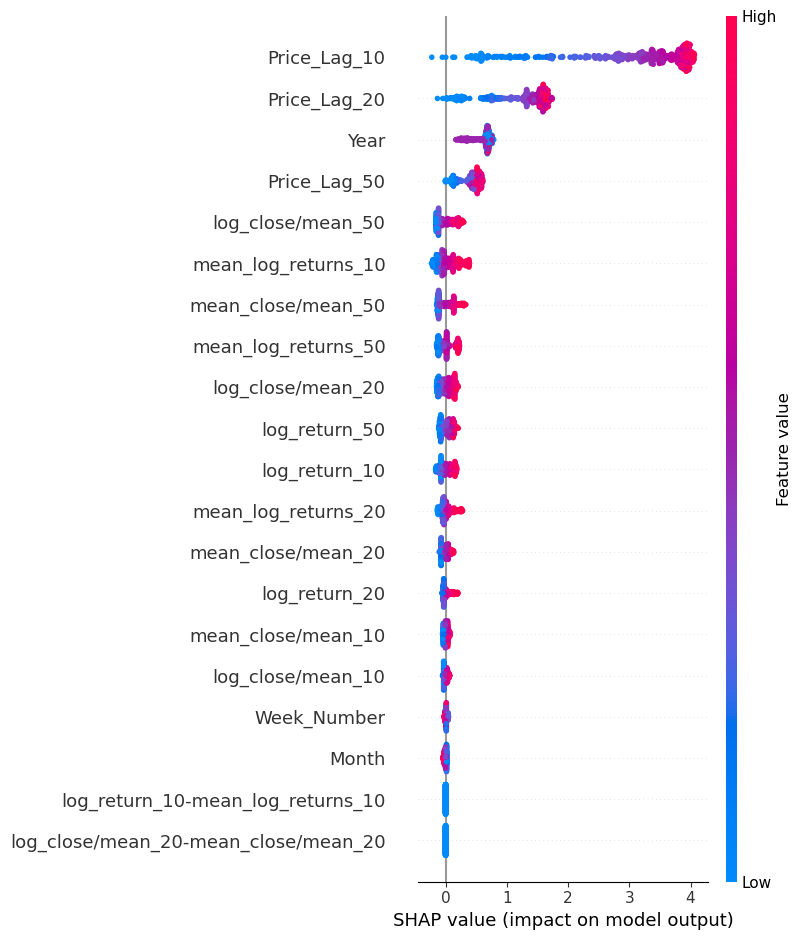

In [38]:
shap.summary_plot(shap_values, pd.DataFrame(results['Silver']['X_test'], columns=df_silver.drop(columns=['Price', 'Date']).columns))

In [39]:
n_fold = 10

In [40]:
def get_time_series_cross_val_splits(data, cv = n_fold, embargo = 3750):
    all_train_timestamps = data['Date'].unique()
    len_split = len(all_train_timestamps) // cv
    test_splits = [all_train_timestamps[i * len_split:(i + 1) * len_split] for i in range(cv)]
    rem = len(all_train_timestamps) - len_split*cv
    if rem>0:
        test_splits[-1] = np.append(test_splits[-1], all_train_timestamps[-rem:])

    train_splits = []
    train_split = None
    for test_split in test_splits:
        test_split_max = int(np.max(test_split))
        test_split_min = int(np.min(test_split))
        train_split_not_embargoed = [e for e in all_train_timestamps if not (test_split_min <= int(e) <= test_split_max)]
        embargo_sec = embargo*60
        train_split = [e for e in train_split_not_embargoed if
                       abs(int(e) - test_split_max) > embargo_sec and abs(int(e) - test_split_min) > embargo_sec]
        train_splits.append(train_split)

    # convenient way to iterate over train and test splits
    train_test_zip = zip(train_splits, test_splits)
    return train_test_zip

In [41]:
# Experiment 2 with cross validation
def runExperimentCV():
    dfs = [df_silver, df_gold, df_copper, df_palladium, df_platinum]
    scaler = MinMaxScaler(feature_range=(-1,1))
    #scaler = StandardScaler()

    all_results = {}
    oof_pred = []
    oof_valid = []

    for d, name in zip(dfs, names):
        data = d

        features = data.drop(columns=['Date', 'Price']).columns.to_list()

        train_test_zip = get_time_series_cross_val_splits(data, cv = n_fold, embargo = 3750)

        for split, train_test_split in enumerate(train_test_zip):

            train_split, test_split = train_test_split
            train_split_index = data['Date'].isin(train_split)
            test_split_index = data['Date'].isin(test_split)

            train_dataset = lgb.Dataset(data.loc[train_split_index, features],
                                        data.loc[train_split_index, 'Price'].values,
                                        feature_name = features,
                                   )
            val_dataset = lgb.Dataset(data.loc[test_split_index, features],
                                      data.loc[test_split_index, 'Price'].values,
                                      feature_name = features,
                                      )
            # Model
            model = lgb.train(
                            params = params,
                            train_set = train_dataset, 
                            valid_sets=[train_dataset, val_dataset],
                            valid_names=['tr', 'vl'],
                            num_boost_round = 5000,    
                            feval = correlation,
                            )
            
            #file = f'models/trained_model_id_{name}_fold{split}.pkl'
            #pickle.dump(model, open(file, 'wb'))
            #print(f"Trained model was saved to 'trained_model_id_{name}_fold{split}.pkl'")

            y_pred = model.predict(data.loc[test_split_index, features])

            all_results[name + str(split)] = {'X_test': data.loc[test_split_index, features], 'y_test': data.loc[test_split_index, 'Price'].values, 'y_pred': y_pred, 'model': model}

    return all_results
    

In [42]:
def plotCVPreds(results):
    fig, axes = plt.subplots(nrows=len(names), ncols=n_fold, figsize=(20, 15)) 
    for n in range(len(names)):
            for s in range(n_fold):
                ax = axes[n, s]
                y_test = results[names[n]+str(s)]['y_test']
                df = pd.DataFrame([y_test]).T.reset_index(drop=True)
                df.columns = [f'Test_Fold_{s}']
                y_pred = results[names[n]+str(s)]['y_pred']
                df[f'Prediction'] = y_pred
                df.plot(ax=ax)
                ax.set_title(f"Training {names[n]}")
                ax.set_xlabel("Columns")
                ax.set_ylabel(f"{names[n]}")
    plt.tight_layout()
    plt.show()

In [43]:
results2 = runExperimentCV()

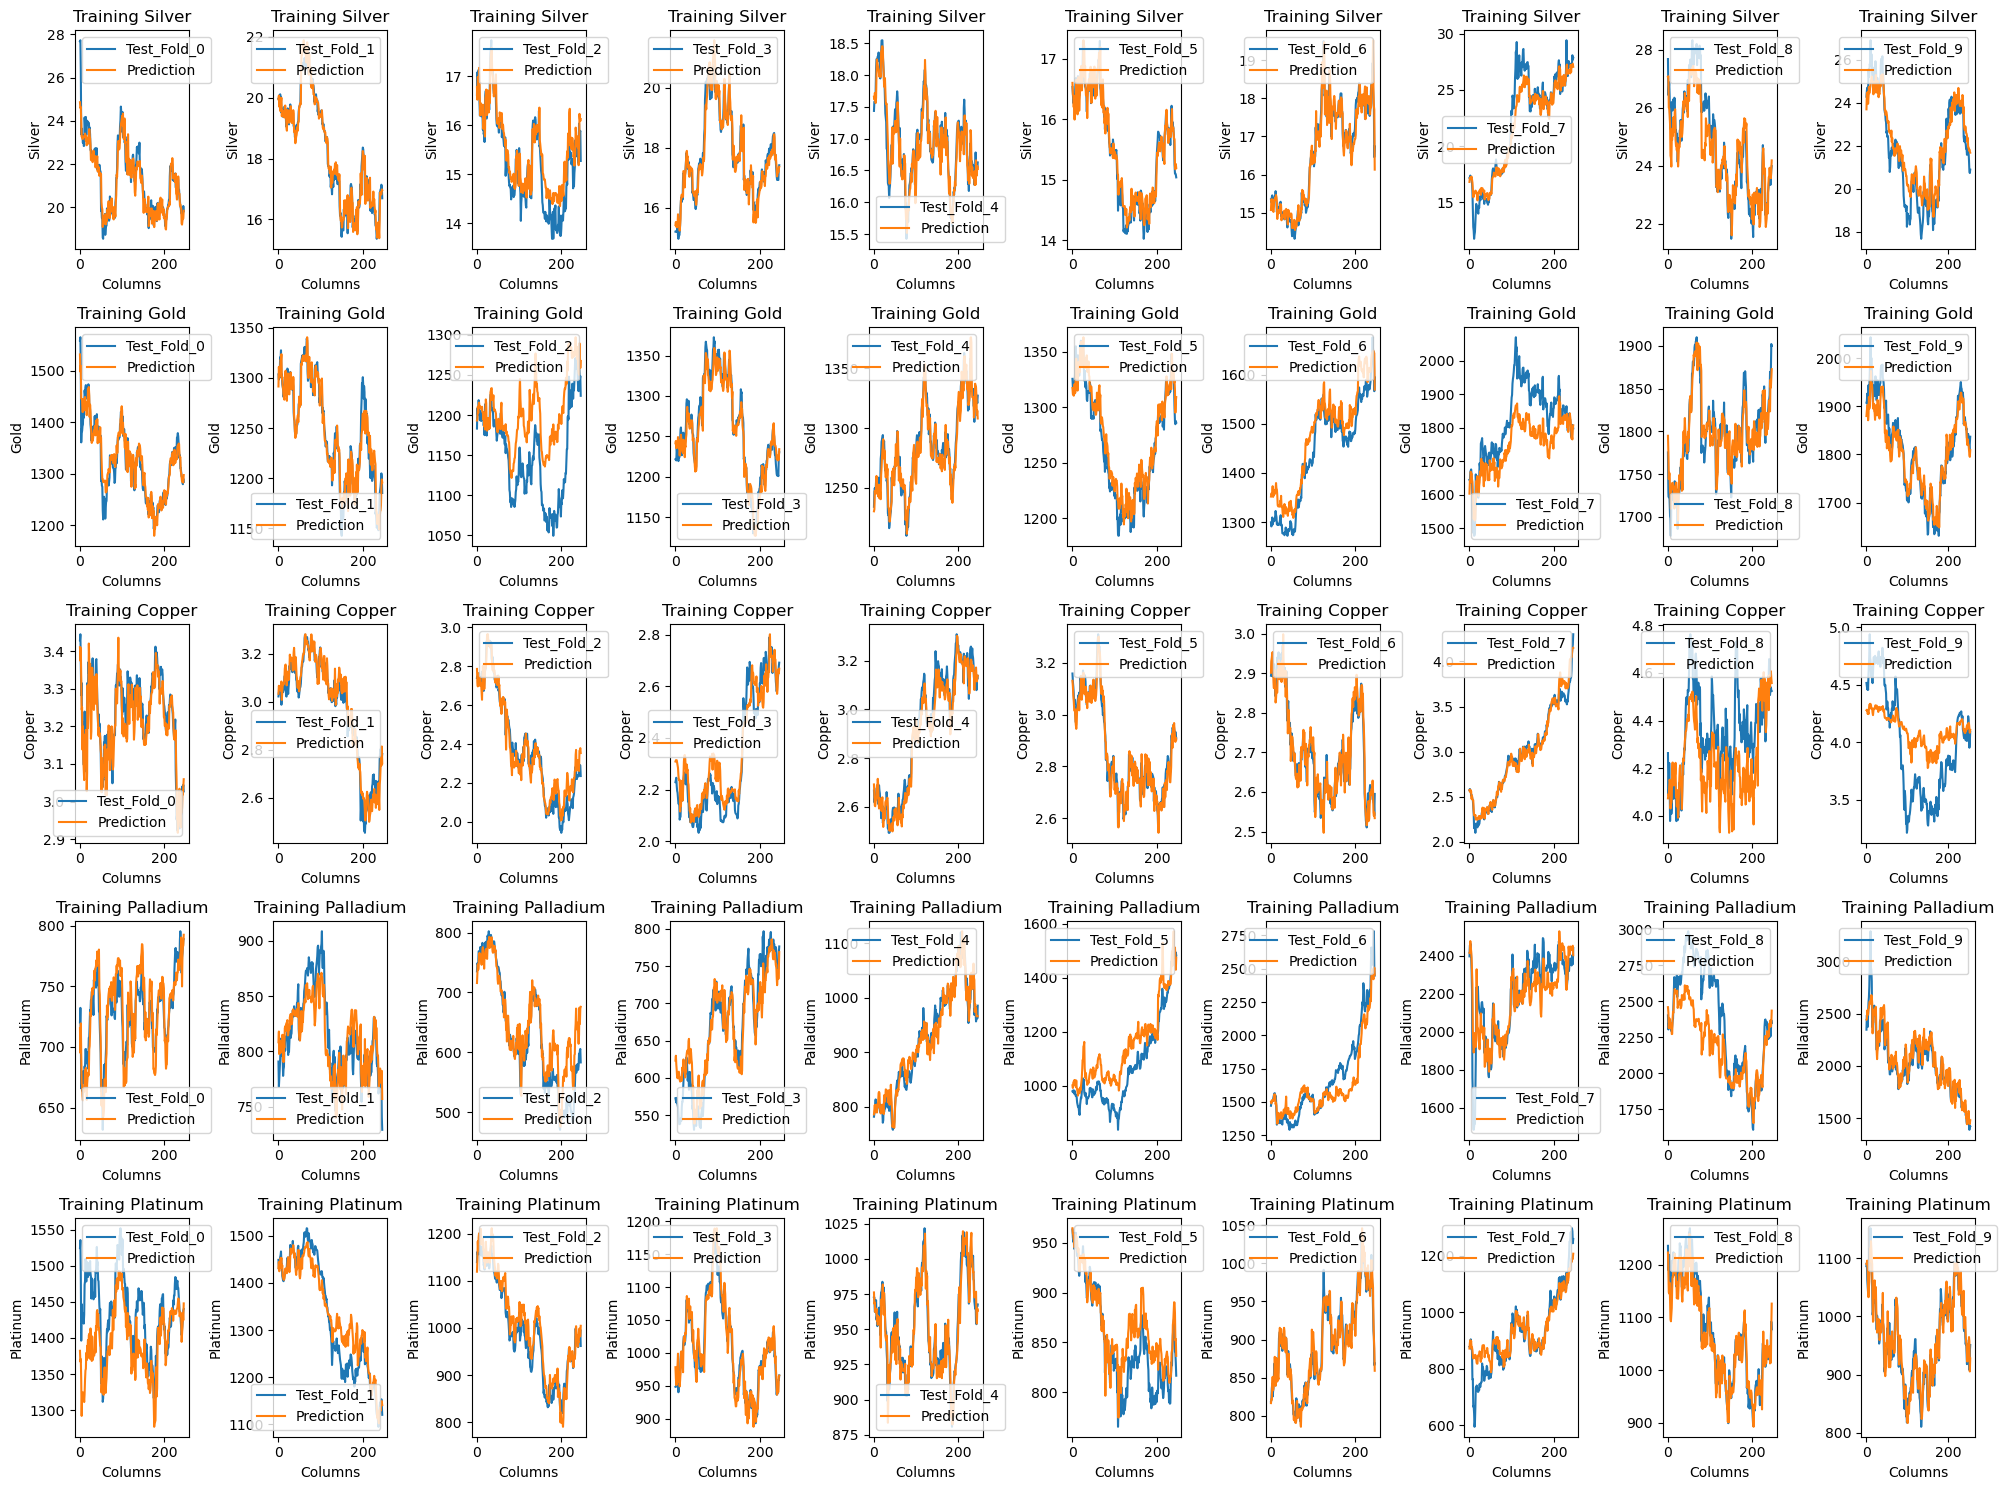

In [44]:
plotCVPreds(results2)

In [45]:
shapname = "Copper"
cvfold = 8

In [46]:
explainer = shap.Explainer(results2[shapname+str(cvfold)]['model'])
#explainer = shap.TreeExplainer(results2[shapname+str(cvfold)]['model'])
shap_values = explainer.shap_values(results2[shapname+str(cvfold)]['X_test'])

/home/stare/anaconda3/envs/test-env/lib/python3.8/site-packages/shap/plots/_beeswarm.py:699: UserWarning:

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored



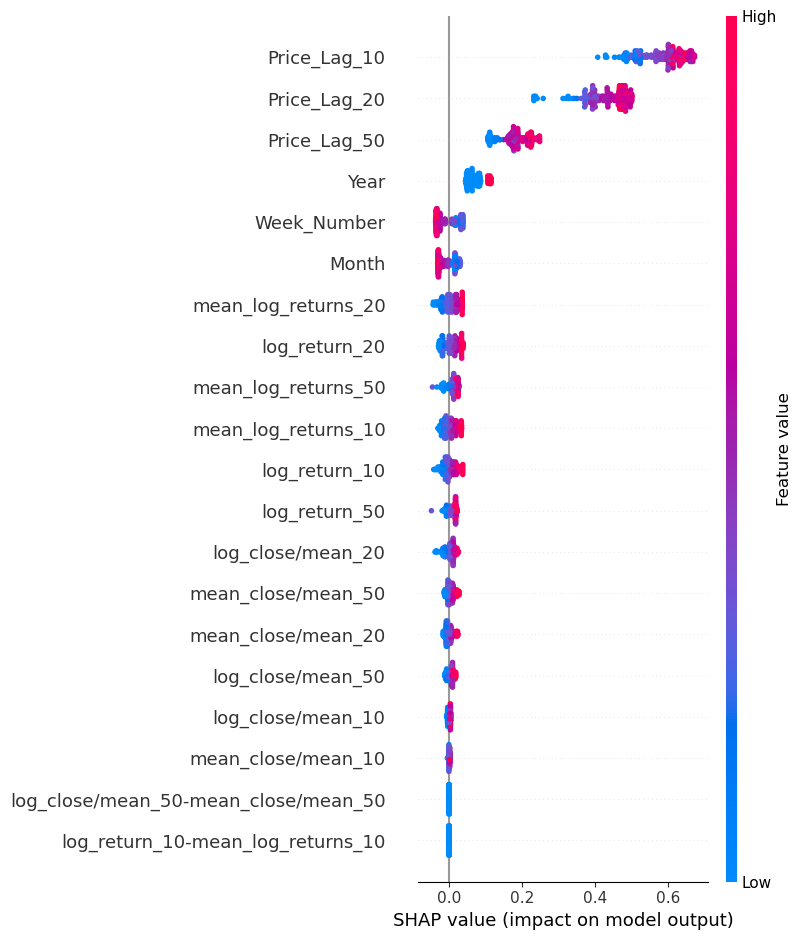

In [47]:
shap.summary_plot(shap_values, pd.DataFrame(results2[shapname+str(cvfold)]['X_test'], columns=results2[shapname+str(cvfold)]['X_test'].columns))

- SHAP: Red Feature Values are higher values, and Blue are lower values. SHAP value is the negative or positive impact.
- In this chart, we have four features which its values, independently of the low or high value, it has a positive impact on the output of the model.

In [48]:
def getScoresCV(results, metric):
    scores = {}
    for name in names:
        score = 0
        for s in range(n_fold):
            score += metric(np.array(results[name+str(s)]['y_pred']),np.array(results[name+str(s)]['y_test']))
        score /= n_fold
        scores[name] = score
    return scores

In [49]:
getScoresCV(results2, corr_score)

{'Silver': 0.956066373167376,
 'Gold': 0.9317829760358691,
 'Copper': 0.9329816195409386,
 'Palladium': 0.9202186047439639,
 'Platinum': 0.9279259611739237}

In [50]:
getScoresCV(results2, mean_absolute_error)

{'Silver': 0.3921180487162751,
 'Gold': 26.193869193163266,
 'Copper': 0.08053150369187656,
 'Palladium': 64.08484041020701,
 'Platinum': 23.12467670913237}

In [51]:
gc.collect()

12680

- Can we improve the results if the model is feed other data, for example the other metals data?

In [52]:
# 26 + (22 * 4) = 114 cols
print(df_silver.shape, df_gold.shape, df_copper.shape, df_palladium.shape, df_platinum.shape)
join = ['Date', 'Year', 'Month', 'Week_Number']
df_metals = pd.merge(df_silver, df_gold, how='inner', on=join, suffixes=('_Silver', '_Gold'))
df_copper_palladium = pd.merge(df_copper, df_palladium, how='inner', on=join, suffixes=('_Copper', '_Palladium'))
df_metals = pd.merge(df_metals, df_copper_palladium, how='inner', on=join)
platinum_cols = {col: col + '_Platinum' for col in df_platinum.columns if col not in join}
df_platinum_renamed = df_platinum.rename(columns=platinum_cols)
df_metals = pd.merge(df_metals, df_platinum_renamed, how='inner', on=join)
print(df_metals.shape)
print(df_metals.columns)

(2478, 26) (2478, 26) (2478, 26) (2478, 26) (2478, 26)
(2478, 114)
Index(['Price_Lag_10_Silver', 'log_close/mean_10_Silver',
       'log_return_10_Silver', 'Price_Lag_20_Silver',
       'log_close/mean_20_Silver', 'log_return_20_Silver',
       'Price_Lag_50_Silver', 'log_close/mean_50_Silver',
       'log_return_50_Silver', 'mean_close/mean_10_Silver',
       ...
       'log_return_10-mean_log_returns_10_Platinum',
       'mean_close/mean_20_Platinum', 'mean_log_returns_20_Platinum',
       'log_close/mean_20-mean_close/mean_20_Platinum',
       'log_return_20-mean_log_returns_20_Platinum',
       'mean_close/mean_50_Platinum', 'mean_log_returns_50_Platinum',
       'log_close/mean_50-mean_close/mean_50_Platinum',
       'log_return_50-mean_log_returns_50_Platinum', 'Price_Platinum'],
      dtype='object', length=114)


In [53]:
df_metals.columns[df_metals.columns.str.contains('Price') &  ~df_metals.columns.str.contains('Lag')].to_list() + ['Date']

['Price_Silver',
 'Price_Gold',
 'Price_Copper',
 'Price_Palladium',
 'Price_Platinum',
 'Date']

In [54]:
# Experiment 2 with cross validation
def runExperimentCV_FullMetal():
    scaler = MinMaxScaler(feature_range=(-1,1))
    #scaler = StandardScaler()

    all_results = {}

    for name in names:

        features = df_metals.drop(columns=df_metals.columns[df_metals.columns.str.contains('Price') &  ~df_metals.columns.str.contains('Lag')].to_list() + ['Date']).columns.to_list()

        train_test_zip = get_time_series_cross_val_splits(df_metals, cv = n_fold, embargo = 3750)

        for split, train_test_split in enumerate(train_test_zip):

            train_split, test_split = train_test_split
            train_split_index = df_metals['Date'].isin(train_split)
            test_split_index = df_metals['Date'].isin(test_split)

            train_dataset = lgb.Dataset(df_metals.loc[train_split_index, features],
                                        df_metals.loc[train_split_index, 'Price_' + name].values,
                                        feature_name = features,
                                   )
            val_dataset = lgb.Dataset(df_metals.loc[test_split_index, features],
                                      df_metals.loc[test_split_index, 'Price_' + name].values,
                                      feature_name = features,
                                      )
            # Model
            model = lgb.train(
                            params = params,
                            train_set = train_dataset, 
                            valid_sets=[train_dataset, val_dataset],
                            valid_names=['tr', 'vl'],
                            num_boost_round = 5000,    
                            feval = correlation,
                            )
            
            #file = f'models/trained_fullmetal_model_id_{name}_fold{split}.pkl'
            #pickle.dump(model, open(file, 'wb'))
            #print(f"Trained model was saved to 'trained_fullmetal_model_id_{name}_fold{split}.pkl'")

            y_pred = model.predict(df_metals.loc[test_split_index, features])

            all_results[name + str(split)] = {'X_test': df_metals.loc[test_split_index, features], 'y_test': df_metals.loc[test_split_index, 'Price_' + name].values, 'y_pred': y_pred, 'model': model}

    return all_results

In [55]:
results3 = runExperimentCV_FullMetal()

/tmp/ipykernel_110745/3087280273.py:16: RuntimeWarning:

divide by zero encountered in double_scalars



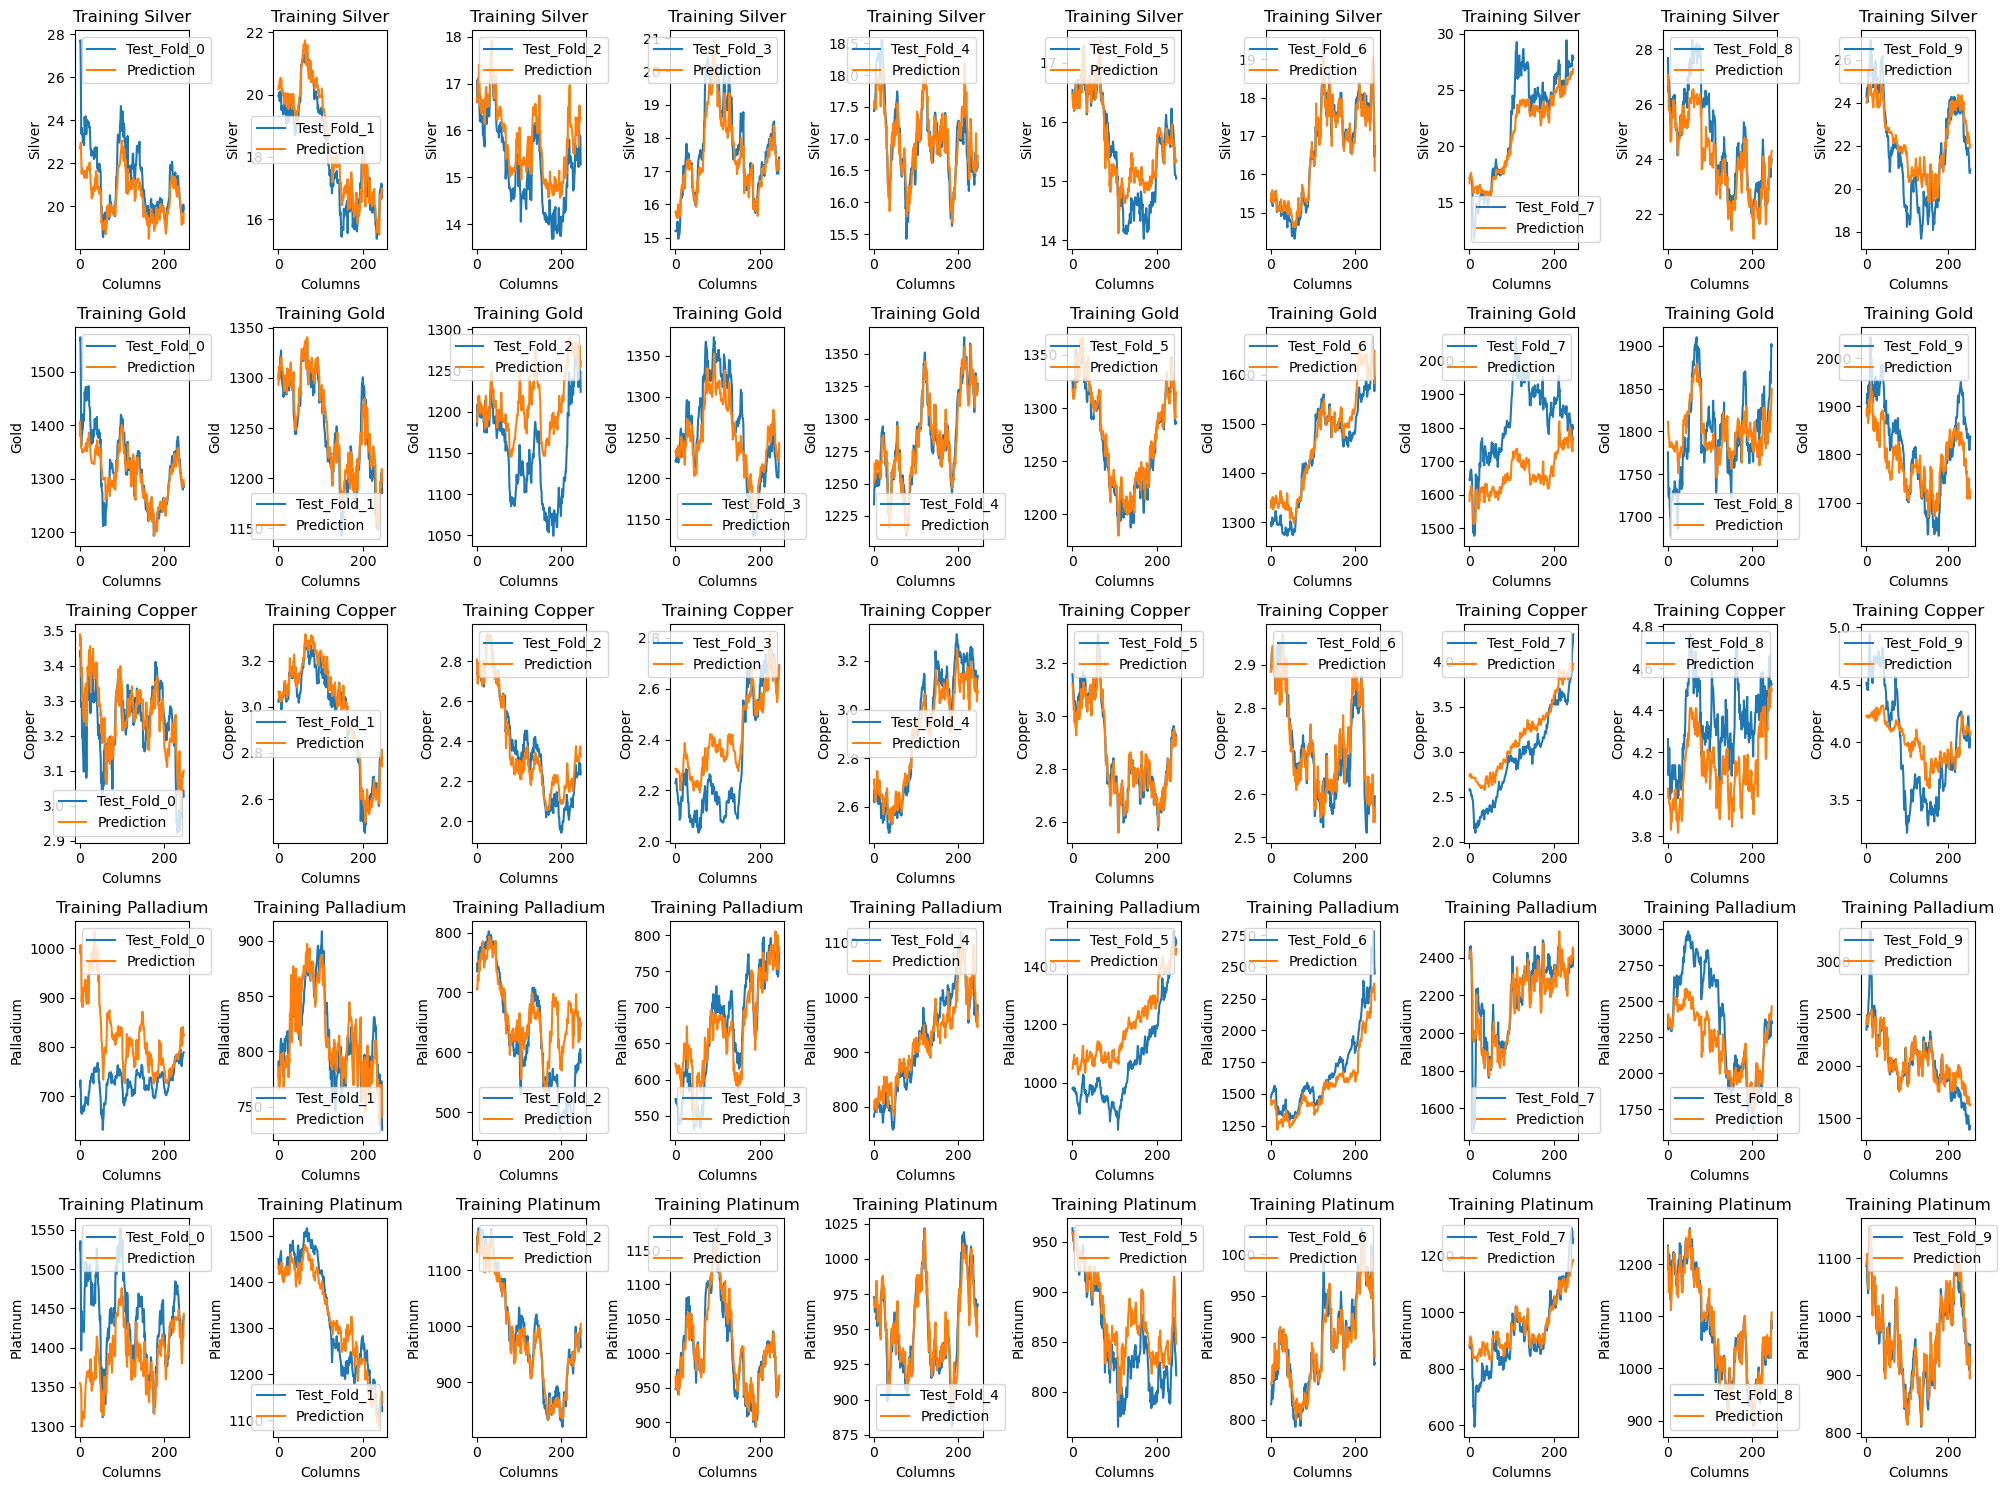

In [56]:
plotCVPreds(results3)

In [57]:
shapname = "Copper"
cvfold = 8

In [58]:
explainer = shap.Explainer(results3[shapname+str(cvfold)]['model'])
#explainer = shap.TreeExplainer(results2[shapname+str(cvfold)]['model'])
shap_values = explainer.shap_values(results3[shapname+str(cvfold)]['X_test'])

/home/stare/anaconda3/envs/test-env/lib/python3.8/site-packages/shap/plots/_beeswarm.py:699: UserWarning:

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored



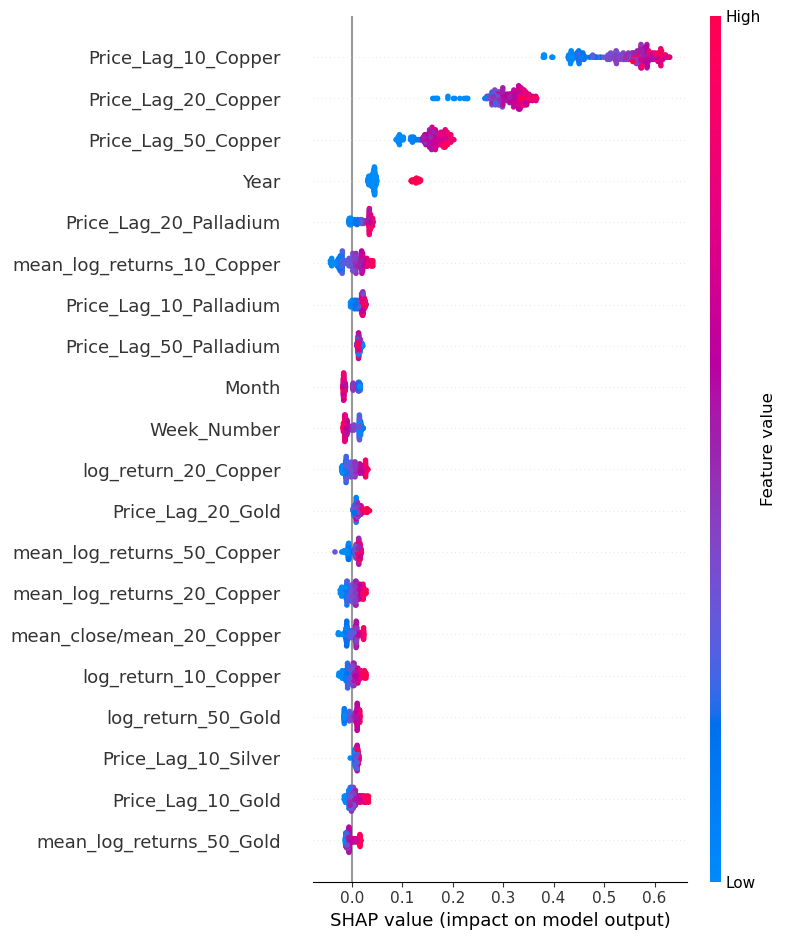

In [59]:
shap.summary_plot(shap_values, pd.DataFrame(results3[shapname+str(cvfold)]['X_test'], columns=results3[shapname+str(cvfold)]['X_test'].columns))

In [60]:
getScoresCV(results2, corr_score)

{'Silver': 0.956066373167376,
 'Gold': 0.9317829760358691,
 'Copper': 0.9329816195409386,
 'Palladium': 0.9202186047439639,
 'Platinum': 0.9279259611739237}

In [61]:
getScoresCV(results3, corr_score)

{'Silver': 0.9368026702389918,
 'Gold': 0.8602177892585665,
 'Copper': 0.9093841598164444,
 'Palladium': 0.8193537207800692,
 'Platinum': 0.9154395545033968}

In [62]:
getScoresCV(results2, mean_absolute_error)

{'Silver': 0.3921180487162751,
 'Gold': 26.193869193163266,
 'Copper': 0.08053150369187656,
 'Palladium': 64.08484041020701,
 'Platinum': 23.12467670913237}

In [63]:
getScoresCV(results3, mean_absolute_error)

{'Silver': 0.6071678749044634,
 'Gold': 40.9754247829542,
 'Copper': 0.11400178458888419,
 'Palladium': 82.45475214550284,
 'Platinum': 24.594223868152913}

- When comparing the results, the standalone version seems achieve better results, but not so much, which makes the multiple metal features model more attrative so we don't end up overfitting.
- But we still need to tune this up a little bit, for example include oil prices, consider covid period, inflation, and more variables.

In [64]:
def exportCSV():
    df_metals.to_csv('train_metals_features.csv')
    df_silver.to_csv('df_silver.csv')
    df_gold.to_csv('df_gold.csv')
    df_copper.to_csv('df_copper.csv')
    df_palladium.to_csv('df_palladium.csv')
    df_platinum.to_csv('df_platinum.csv')
exportCSV()

In [65]:
df_metals.shape

(2478, 114)

In [66]:
# Experiment 2 with cross validation
def runExperimentCV_FullMetal():
    scaler = MinMaxScaler(feature_range=(-1,1))
    #scaler = StandardScaler()

    all_results = {}

    for name in names:

        features = df_metals.drop(columns=df_metals.columns[df_metals.columns.str.contains('Price') &  ~df_metals.columns.str.contains('Lag')].to_list() + ['Date']).columns.to_list()

        train_test_zip = get_time_series_cross_val_splits(df_metals, cv = n_fold, embargo = 3750)

        for split, train_test_split in enumerate(train_test_zip):

            train_split, test_split = train_test_split
            train_split_index = df_metals['Date'].isin(train_split)
            test_split_index = df_metals['Date'].isin(test_split)

            train_dataset = lgb.Dataset(df_metals.loc[train_split_index, features],
                                        df_metals.loc[train_split_index, 'Price_' + name].values,
                                        feature_name = features,
                                   )
            val_dataset = lgb.Dataset(df_metals.loc[test_split_index, features],
                                      df_metals.loc[test_split_index, 'Price_' + name].values,
                                      feature_name = features,
                                      )
            # Model
            model = lgb.train(
                            params = params,
                            train_set = train_dataset, 
                            valid_sets=[train_dataset, val_dataset],
                            valid_names=['tr', 'vl'],
                            num_boost_round = 5000,    
                            feval = correlation,
                            )
            
            #file = f'models/trained_fullmetal_model_id_{name}_fold{split}.pkl'
            #pickle.dump(model, open(file, 'wb'))
            #print(f"Trained model was saved to 'trained_fullmetal_model_id_{name}_fold{split}.pkl'")

            y_pred = model.predict(df_metals.loc[test_split_index, features])

            all_results[name + str(split)] = {'X_test': df_metals.loc[test_split_index, features], 'y_test': df_metals.loc[test_split_index, 'Price_' + name].values, 'y_pred': y_pred, 'model': model}

    return all_results

In [67]:
glob_df = pd.read_csv('./datasets/Finance/interestrates/EO_18102023022850125.csv')
glob_df.head()

LOCATION Country VARIABLE                  Variable FREQUENCY  Frequency  \
0      CAN  Canada      IRS  Short-term interest rate         Q  Quarterly   
1      CAN  Canada      IRS  Short-term interest rate         Q  Quarterly   
2      CAN  Canada      IRS  Short-term interest rate         Q  Quarterly   
3      CAN  Canada      IRS  Short-term interest rate         Q  Quarterly   
4      CAN  Canada      IRS  Short-term interest rate         Q  Quarterly   

      TIME     Time Unit Code        Unit  PowerCode Code PowerCode  \
0  2013-Q1  Q1-2013        PC  Percentage               0     Units   
1  2013-Q2  Q2-2013        PC  Percentage               0     Units   
2  2013-Q3  Q3-2013        PC  Percentage               0     Units   
3  2013-Q4  Q4-2013        PC  Percentage               0     Units   
4  2014-Q1  Q1-2014        PC  Percentage               0     Units   

   Reference Period Code  Reference Period     Value  Flag Codes  Flags  
0                    NaN               NaN  1.160000         NaN    NaN  
1                    NaN               NaN  1.160667         NaN    NaN  
2                    NaN               NaN  1.168424         NaN    NaN  
3                    NaN               NaN  1.168606         NaN    NaN  
4                    NaN               NaN  1.170000         NaN    NaN

In [68]:
glob_df['TIME'] = glob_df['TIME'].str.replace('-', '')

In [69]:
glob_df['TIME'] = pd.to_datetime(glob_df['TIME'])

In [70]:
px.line(glob_df[glob_df['VARIABLE'] == 'IRS'], x='TIME', y='Value', color='Country', title='IRS top metal producing countries')

In [71]:
px.line(glob_df[glob_df['VARIABLE'] == 'IRL'], x='TIME', y='Value', color='Country', title='IRL top metal producing countries')

In [72]:
df_pivoted = glob_df.pivot(index='TIME', columns=['Country', 'VARIABLE'], values='Value')
df_pivoted.columns = [f'{col[0]}_{col[1]}' for col in df_pivoted.columns]
df_pivoted = df_pivoted.fillna(0)
df_pivoted.describe()

Canada_IRS  Chile_IRS  Mexico_IRS  Chile_IRL  United States_IRS  \
count   43.000000  43.000000   43.000000  43.000000          43.000000   
mean     1.458308   4.146190    5.924574   4.540938           1.249435   
std      1.215200   3.048393    2.473176   0.999395           1.438626   
min      0.183438   0.214109    2.883333   2.508526           0.100000   
25%      0.806159   2.682674    3.818333   4.208381           0.150000   
50%      1.168606   3.493492    5.460000   4.514602           0.582354   
75%      1.814765   4.633560    7.653333   5.164441           1.966667   
max      4.742763  11.301044   11.253333   6.656431           5.350000   

       Mexico_IRL  Canada_IRL  United States_IRL  \
count   43.000000   43.000000          43.000000   
mean     7.124916    1.867291           2.281705   
std      1.169925    0.686860           0.813972   
min      5.280000    0.546462           0.650000   
25%      6.400835    1.443778           1.795000   
50%      6.786354    1.857795           2.243333   
75%      7.483431    2.298405           2.753333   
max     10.150000    3.162730           4.400000   

       China (People's Republic of)_IRS  South Africa_IRS  South Africa_IRL  
count                         43.000000         43.000000         43.000000  
mean                           4.699612          5.991332          9.242865  
std                            0.650229          1.305717          1.058356  
min                            4.300000          3.607586          7.284470  
25%                            4.350000          5.087265          8.601453  
50%                            4.350000          6.303330          9.127742  
75%                            4.516667          7.172318          9.825024  
max                            6.000000          7.477938         11.431235